In [1]:
from paths import models_folder, metadata_folder, latent_space_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_abs_diff_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_dense_512_128_32_8_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_max_pool_64_32_16_8_stride_4_B1H_Inst_center_scale_10

In [6]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_2049_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_2049_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_znorm_rolling_avg_std_window_2049_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"])
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           960       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

Apr/09 19:11:05 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Apr/09 19:11:05 pyobsbox.generator INFO: shuffle: True
Apr/09 19:11:05 pyobsbox.generator INFO: seed: 42
Apr/09 19:11:05 pyobsbox.generator INFO: batch_size: 8192
Apr/09 19:11:05 pyobsbox.generator INFO: sequence_length: 2048
Apr/09 19:11:05 pyobsbox.generator INFO: n_bunches: 256
Apr/09 19:11:05 pyobsbox.generator INFO: __len__: 1034
Apr/09 19:11:05 pyobsbox.generator INFO: fetched_log_folder: None
Apr/09 19:11:05 pyobsbox.generator INFO: fetched_log_prefix: 
Apr/09 19:11:05 pyobsbox.generator INFO: normalization: znorm
Apr/09 19:11:05 pyobsbox.generator INFO: normalization_pre_split: False
Apr/09 19:11:06 pyobsbox.generator INFO: normalization_kwargs: {}
Apr/09 19:11:06 pyobsbox.generator INFO: abs_diff: False
Apr/09 19:11:06 pyobsbox.generator INFO: diff: False
Apr/09 19:11:06 pyobsbox.generator INFO: rolling_avg: True
Apr/09 19:11:06 pyobsbox

In [9]:
print(train_metadata.shape)
train_metadata.head()

(264704, 11)


type  fill  beam plane  q           date_time  \
7246687  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889961  Inst  7464     1     h  7 2018-11-22 05:09:14   
1617893  Inst  6663     1     h  7 2018-05-10 15:13:15   
6142636  Inst  6953     1     h  7 2018-07-21 06:32:07   
593510   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7246687  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889961  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/...        460   
1617893  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6142636  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593510   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7246687       1168.0         852.0      65536  
6889961       2527.0         339.0      65536  
1617893       2032.0        1482.0      65536  
6142636       1170.0         854.0      65536  
593510        2034.0        1117.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(3840, 11)


type  fill  beam plane  q           date_time  \
11039517  Inst  7052     1     h  7 2018-08-13 20:47:14   
685752    Inst  7063     1     h  7 2018-08-18 14:51:12   
1971755   Inst  6343     1     h  7 2017-10-28 09:42:14   
6482399   Inst  6587     1     h  7 2018-04-21 16:03:14   
10323637  Inst  7325     1     h  7 2018-10-21 18:55:45   

                                                       file  n_bunches  \
11039517  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7052/...       2556   
685752    /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7063/...        780   
1971755   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6343/...       1868   
6482399   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6587/...       1116   
10323637  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7325/...        252   

          bunch_index  bunch_number  ts_length  
11039517        619.0         442.0      65536  
685752          704.0         513.0      65536  
1971755         831.0         434.0      65536  
6482399        1085.0         449.0      65536  
10323637        294.0         200.0      65536

# Loss functions

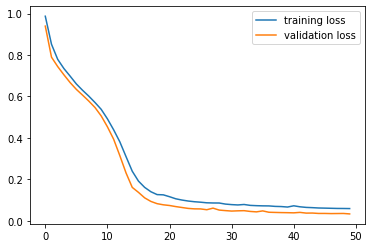

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
train_dataset = np.vstack([train_generator[i][0] for i in tqdm(range(50))])
train_dataset.shape

(396800, 2048, 2)

In [13]:
validation_dataset = np.vstack([validation_generator[i][0] for i in tqdm(range(5))])
validation_dataset.shape

(39680, 2048, 2)

# Predictions

In [14]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

49/49 [==============================] - 60s 1s/step


(396800, 2048, 2)

In [15]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 981ms/step


(39680, 2048, 2)

In [20]:
MAE_train = abs(train_pred - train_dataset).mean(axis=(1, 2)).squeeze()
MAE_train.shape

(396800,)

In [21]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=(1, 2)).squeeze()
MAE_validation.shape

(39680,)

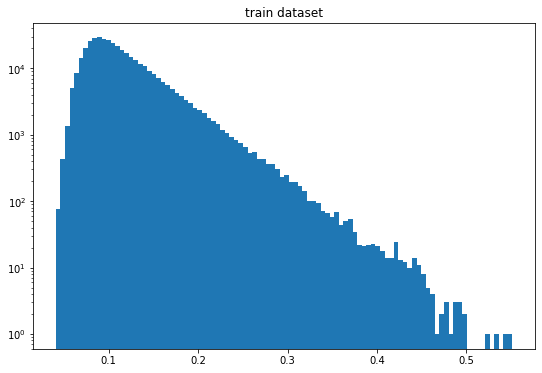

In [22]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [23]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.0868274950710683

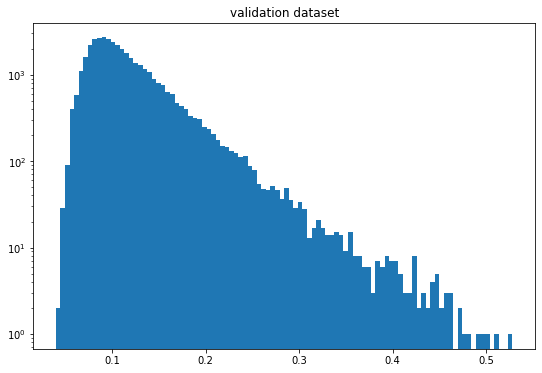

In [24]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [25]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.0884076640916828

In [26]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [27]:
max_MAE_indices

array([149867, 384610, 246564, ..., 207137, 158258, 130506])

In [36]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal[:, 0])
    axes[0].plot(pred_signal[:, 0])

    axes[1].plot(true_signal[:, 1])
    axes[1].plot(pred_signal[:, 1])
#     axes[1].plot(np.abs(np.diff(true_signal)))
#     axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

index:  149867
MAE:  0.5514533704274367
n_bunches       926
bunch_index     549
bunch_number    397
Name: 10795278, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6693/instability_data/06693_Inst_B1H_Q7_20180516_20h19m14s.h5


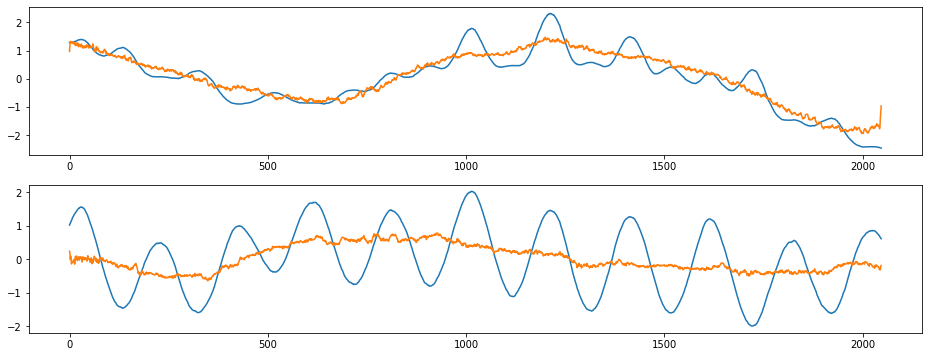

In [37]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal);

# Top rightmost signals

index:  149867
MAE:  0.5514533704274367
n_bunches       926
bunch_index     549
bunch_number    397
Name: 10795278, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6693/instability_data/06693_Inst_B1H_Q7_20180516_20h19m14s.h5


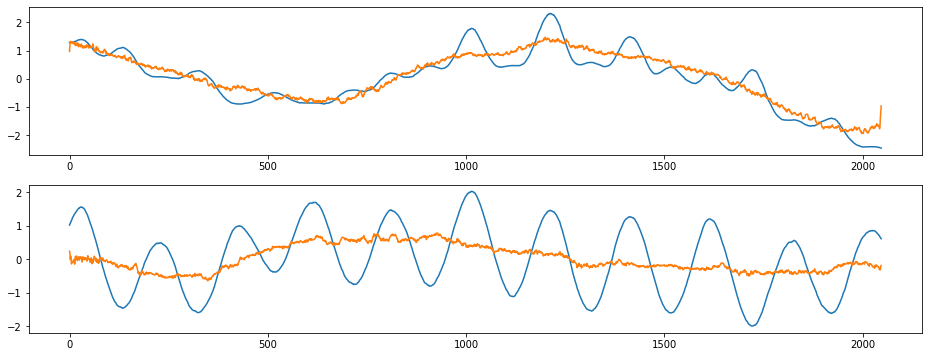

index:  384610
MAE:  0.5435191867503344
n_bunches       540
bunch_index     289
bunch_number    176
Name: 7321442, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6672/instability_data/06672_Inst_B1H_Q7_20180511_17h43m26s.h5


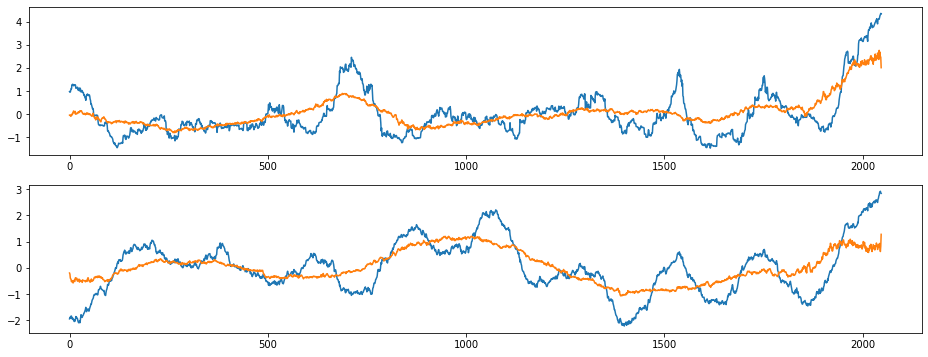

index:  246564
MAE:  0.5312561398517012
n_bunches       252
bunch_index     162
bunch_number     16
Name: 492317, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6576/instability_data/06576_Inst_B1H_Q7_20180419_19h22m52s.h5


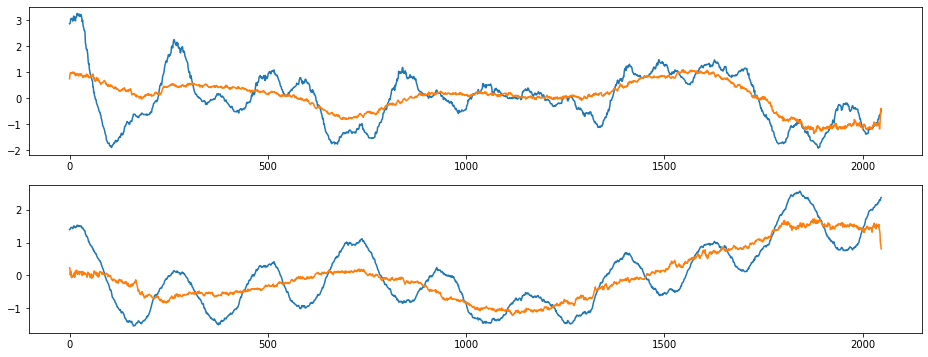

index:  88822
MAE:  0.5239509547789449
n_bunches       216
bunch_index      52
bunch_number      8
Name: 5288374, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_09h00m14s.h5


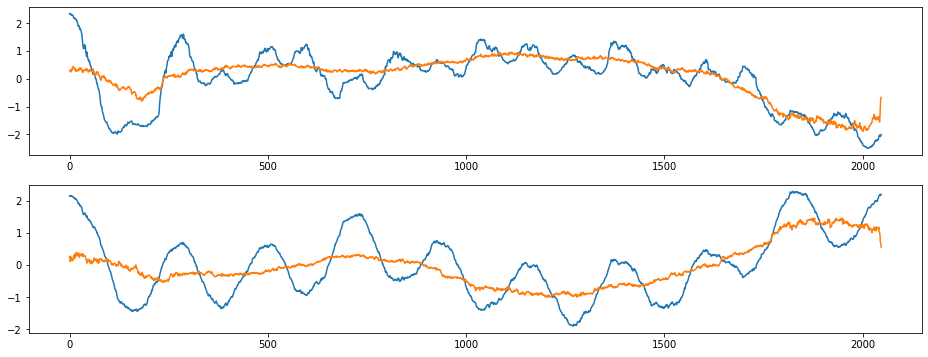

index:  3755
MAE:  0.4994455500005438
n_bunches        396
bunch_index     1145
bunch_number     393
Name: 8558283, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6396/instability_data/06396_Inst_B1H_Q7_20171116_22h07m05s.h5


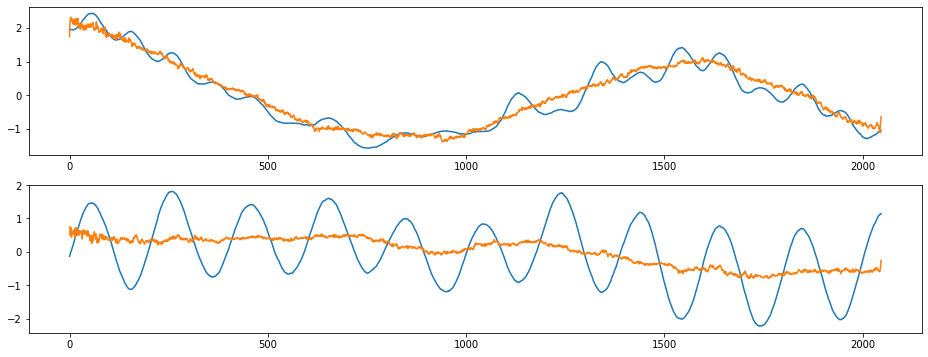

index:  221148
MAE:  0.49683955524330115
n_bunches       292
bunch_index     188
bunch_number     87
Name: 1468073, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/instability_data/06254_Inst_B1H_Q7_20170929_05h31m15s.h5


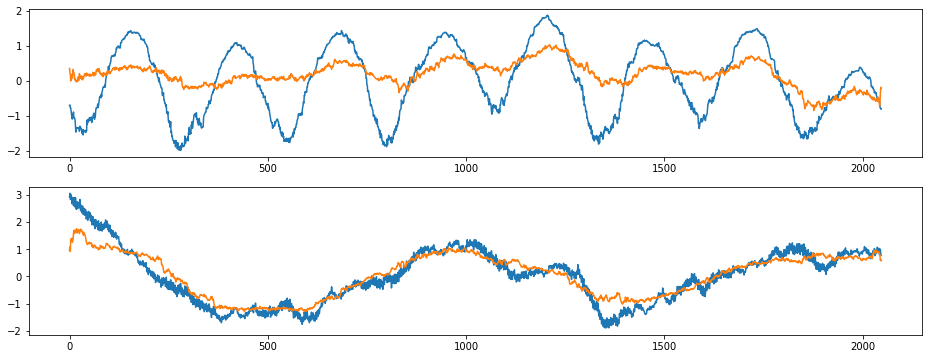

index:  362886
MAE:  0.4922952283855664
n_bunches       396
bunch_index     367
bunch_number    190
Name: 2630550, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_12h30m14s.h5


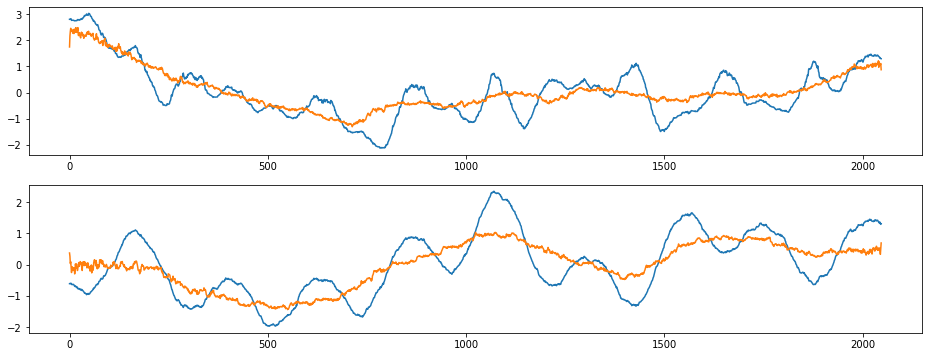

index:  135253
MAE:  0.491361819535928
n_bunches       2556
bunch_index     1852
bunch_number    1347
Name: 2270229, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_07h16m14s.h5


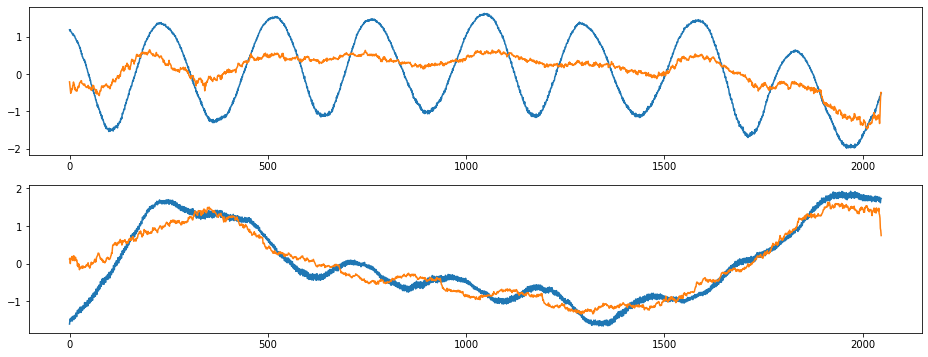

index:  96497
MAE:  0.4906566256442923
n_bunches       924
bunch_index     147
bunch_number     91
Name: 2958333, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7271/instability_data/07271_Inst_B1H_Q7_20181009_17h18m56s.h5


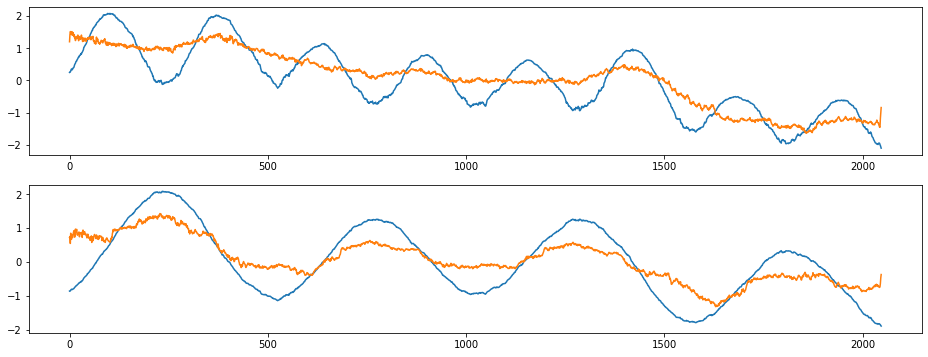

index:  238152
MAE:  0.48887903851530845
n_bunches       428
bunch_index     580
bunch_number    304
Name: 9291719, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6357/instability_data/06357_Inst_B1H_Q7_20171102_15h39m14s.h5


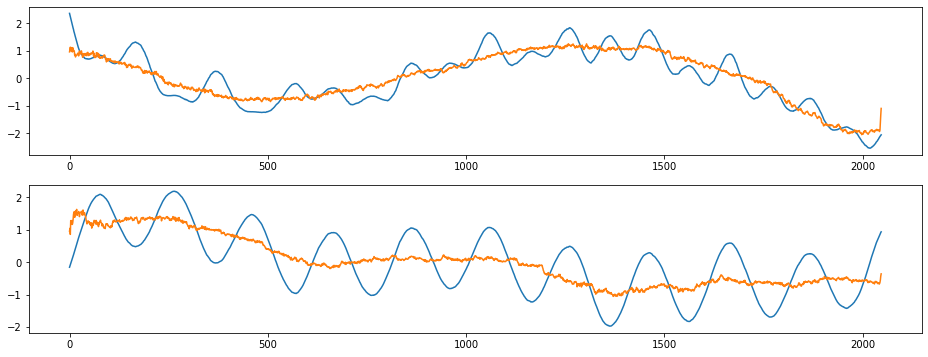

In [38]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Top leftmost signals

index:  130506
MAE:  0.04087548542043844
n_bunches       1868
bunch_index     1534
bunch_number     829
Name: 3538619, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_14h39m14s.h5


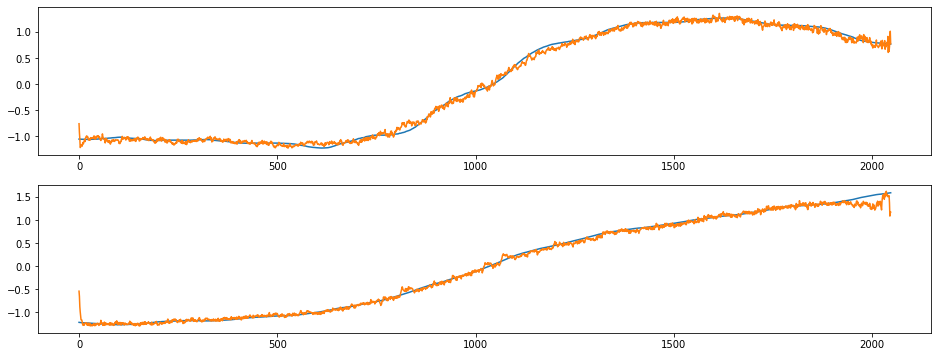

index:  158258
MAE:  0.0417306575917285
n_bunches       2556
bunch_index     3311
bunch_number    2461
Name: 2584334, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7259/instability_data/07259_Inst_B1H_Q7_20181005_02h39m14s.h5


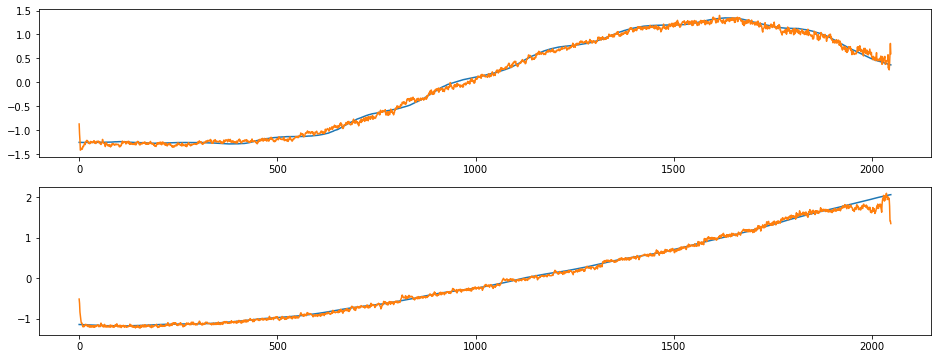

index:  207137
MAE:  0.04175235823735654
n_bunches       672
bunch_index     417
bunch_number    108
Name: 8925805, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6585/instability_data/06585_Inst_B1H_Q7_20180421_12h48m14s.h5


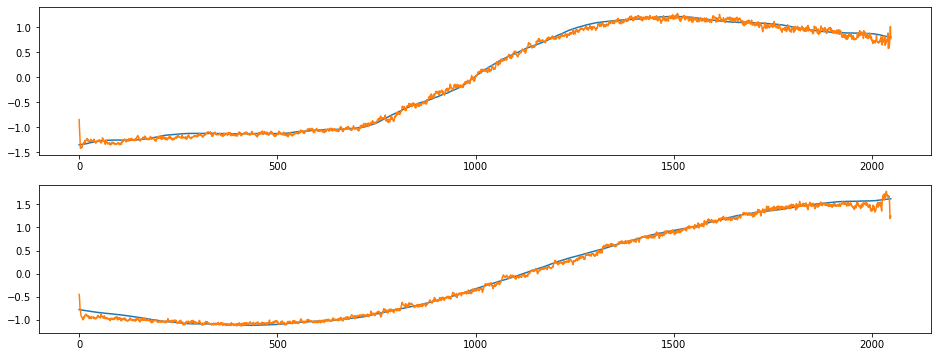

index:  322920
MAE:  0.04179790179728794
n_bunches       2556
bunch_index     1118
bunch_number     809
Name: 2753232, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6956/instability_data/06956_Inst_B1H_Q7_20180721_20h10m10s.h5


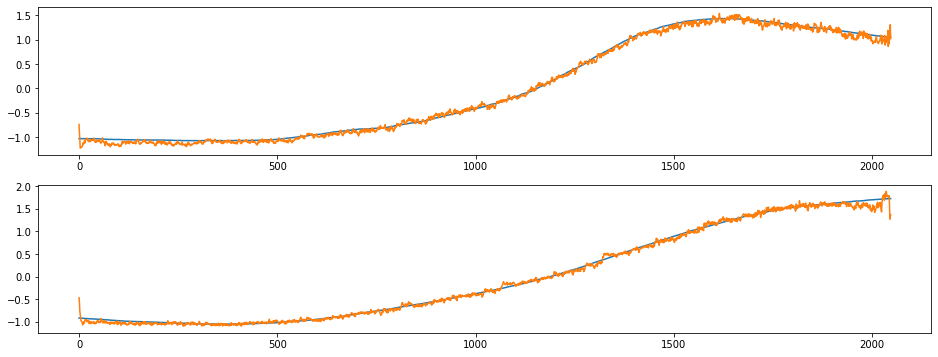

index:  182395
MAE:  0.042573829771125504
n_bunches        468
bunch_index     1644
bunch_number     462
Name: 7128903, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6576/instability_data/06576_Inst_B1H_Q7_20180419_19h33m14s.h5


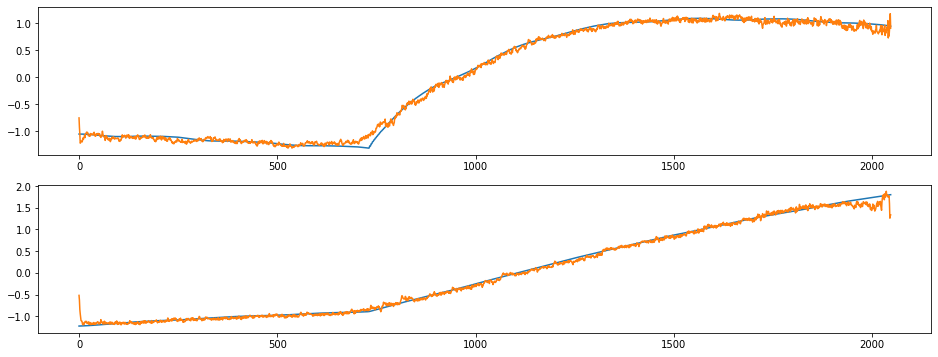

index:  124658
MAE:  0.042623381204067896
n_bunches       1916
bunch_index     1493
bunch_number     818
Name: 6002021, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_23h32m15s.h5


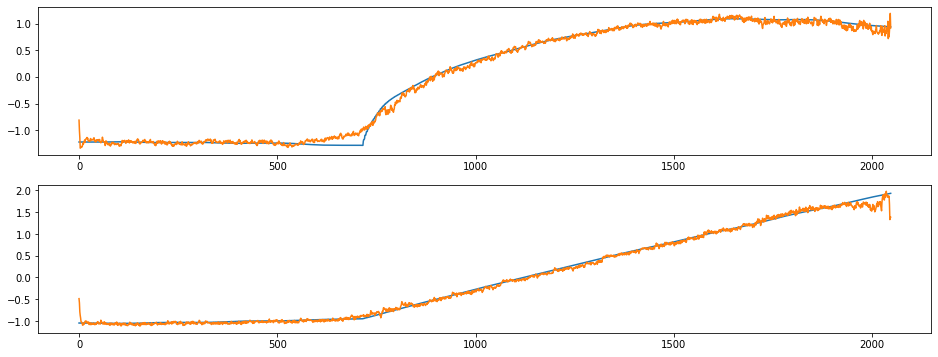

index:  316440
MAE:  0.04271055213339294
n_bunches       648
bunch_index     517
bunch_number     94
Name: 8149928, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181115_20h29m13s.h5


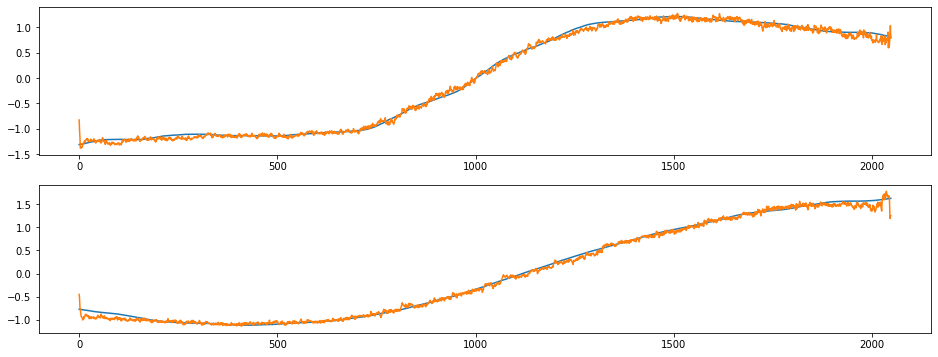

index:  356594
MAE:  0.04275711226318436
n_bunches       396
bunch_index     102
bunch_number     32
Name: 4640125, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7355/instability_data/07355_Inst_B1H_Q7_20181025_21h46m15s.h5


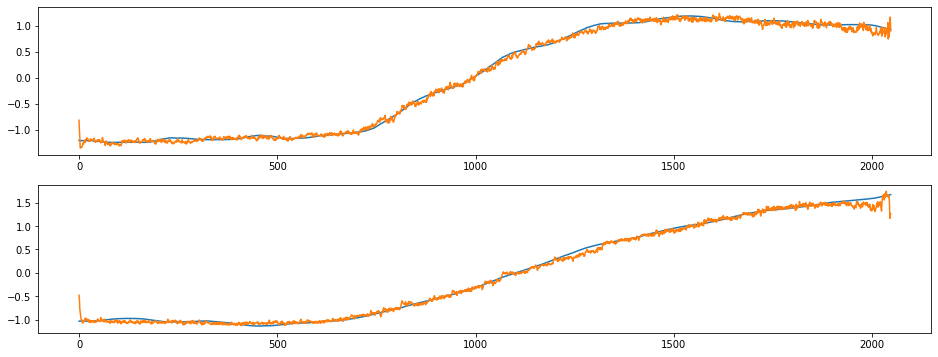

index:  389533
MAE:  0.04278771515024067
n_bunches       636
bunch_index     840
bunch_number    607
Name: 7142164, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7123/instability_data/07123_Inst_B1H_Q7_20180903_17h38m29s.h5


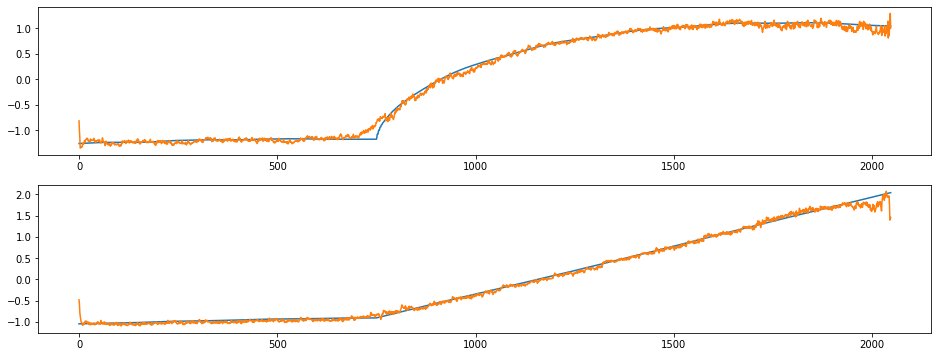

index:  48652
MAE:  0.04288523981896253
n_bunches        229
bunch_index     1015
bunch_number     212
Name: 6414425, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_17h42m39s.h5


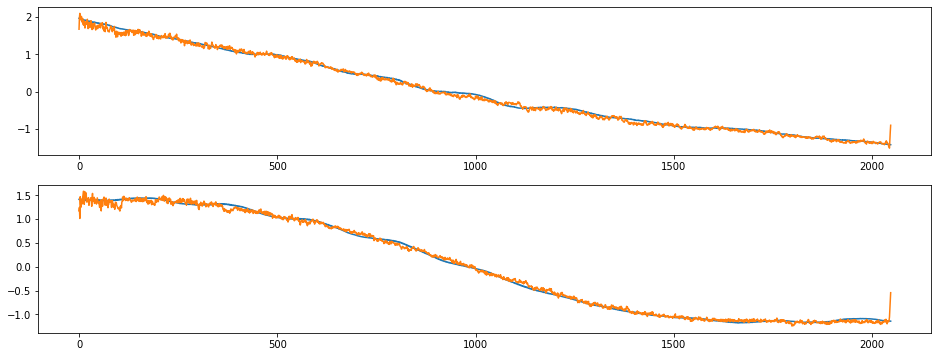

In [39]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# Signals around the peak

In [40]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  161077
MAE:  0.08682752508046426
n_bunches        648
bunch_index     3292
bunch_number     615
Name: 4447664, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7447/instability_data/07447_Inst_B1H_Q7_20181116_05h50m16s.h5


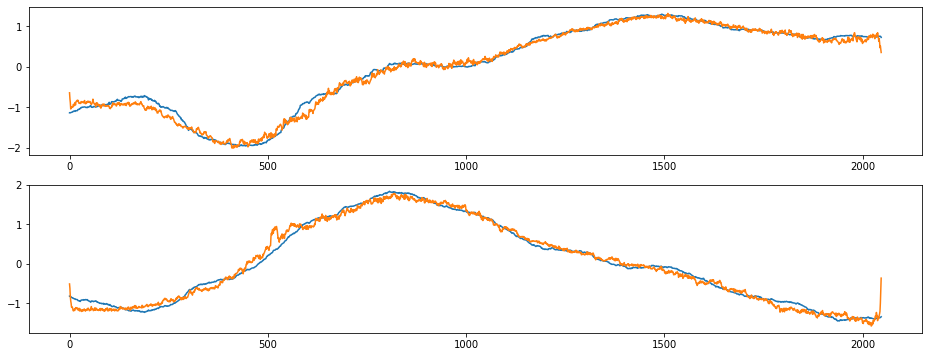

index:  202654
MAE:  0.08682745910293968
n_bunches       1916
bunch_index      809
bunch_number     439
Name: 8740973, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6191/instability_data/06191_Inst_B1H_Q7_20170912_04h06m14s.h5


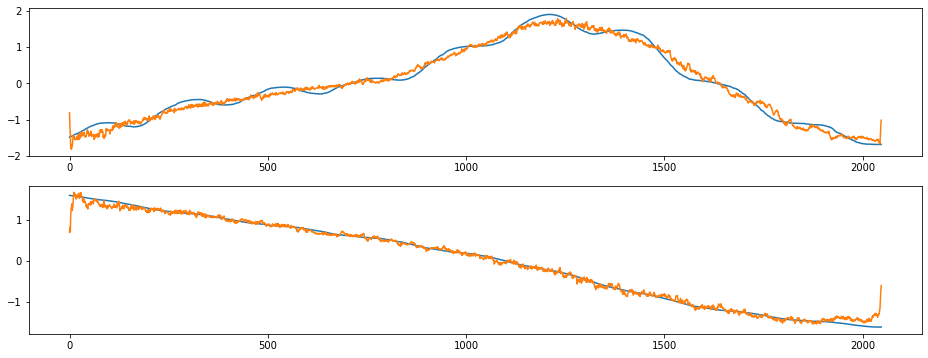

index:  191371
MAE:  0.08682744778019058
n_bunches       1868
bunch_index     1960
bunch_number    1045
Name: 6792051, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_05h41m14s.h5


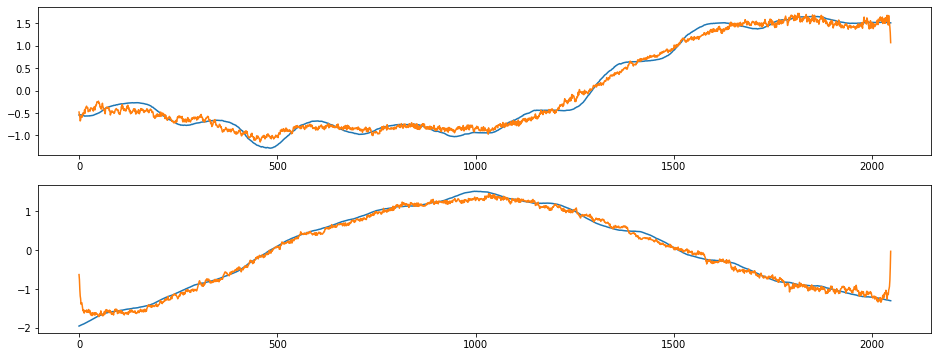

index:  252179
MAE:  0.08682758817076469
n_bunches        733
bunch_index     2455
bunch_number     519
Name: 131987, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_09h26m16s.h5


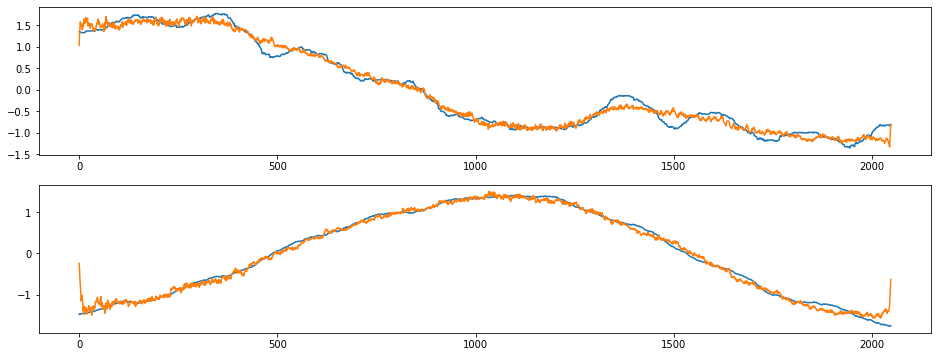

index:  49206
MAE:  0.08682738003581755
n_bunches       2556
bunch_index     1187
bunch_number     871
Name: 10152507, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7105/instability_data/07105_Inst_B1H_Q7_20180830_19h44m15s.h5


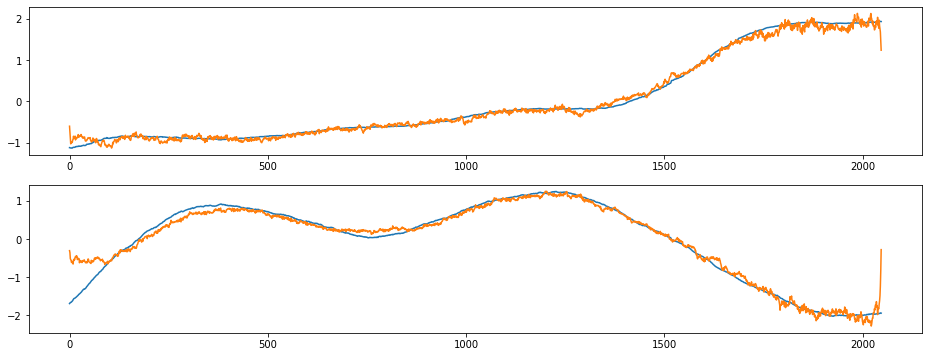

index:  227642
MAE:  0.08682764683046082
n_bunches       987
bunch_index     182
bunch_number     56
Name: 11251718, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6616/instability_data/06616_Inst_B1H_Q7_20180427_05h57m13s.h5


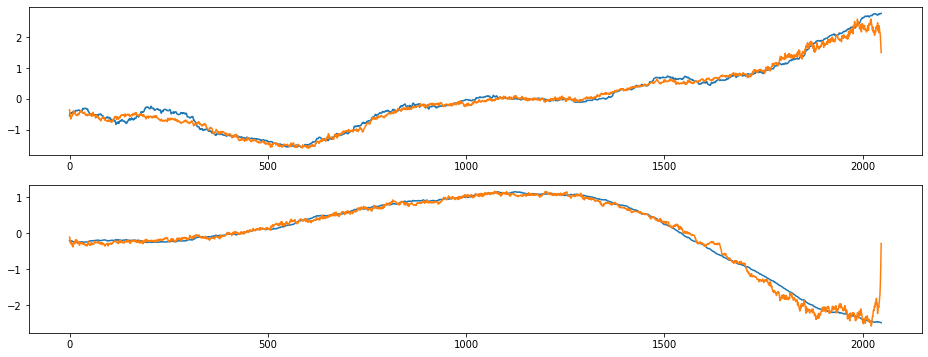

index:  293401
MAE:  0.08682733621638522
n_bunches        648
bunch_index     1761
bunch_number     328
Name: 9757191, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7453/instability_data/07453_Inst_B1H_Q7_20181118_06h51m15s.h5


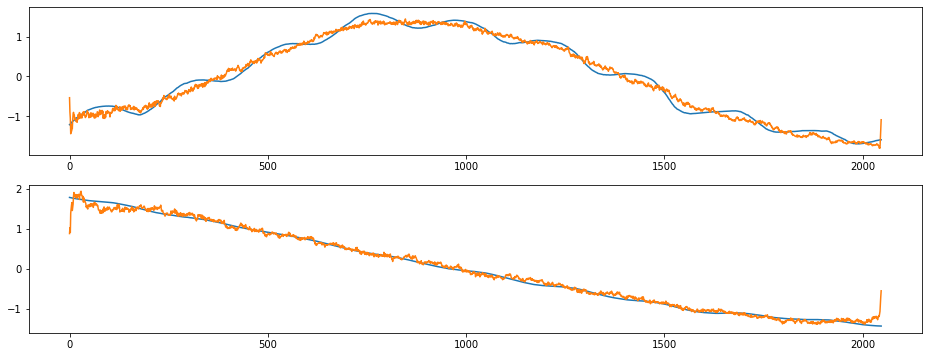

index:  370672
MAE:  0.08682769405732588
n_bunches       1452
bunch_index     3350
bunch_number    1424
Name: 544521, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6890/instability_data/06890_Inst_B1H_Q7_20180705_23h53m14s.h5


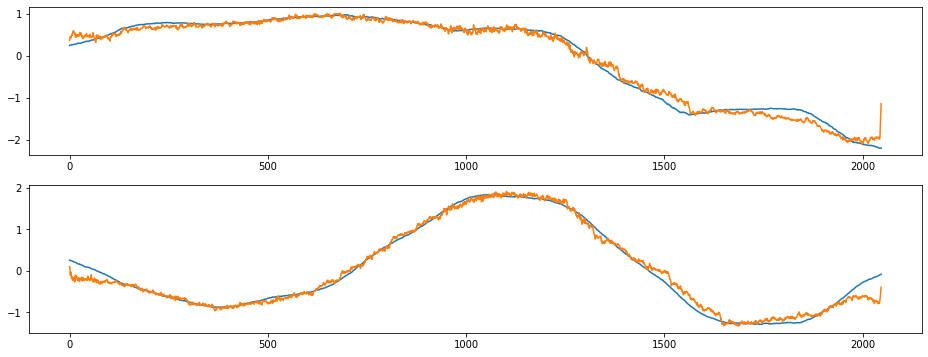

index:  203945
MAE:  0.08682770036966692
n_bunches       2556
bunch_index     1588
bunch_number    1163
Name: 8168507, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6700/instability_data/06700_Inst_B1H_Q7_20180519_14h35m14s.h5


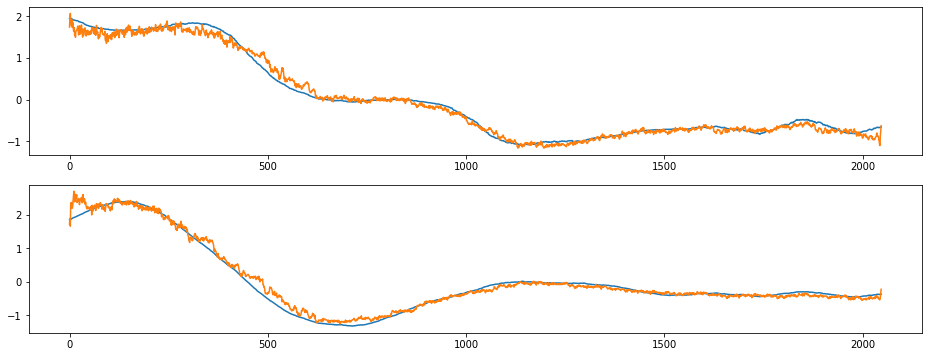

index:  103986
MAE:  0.08682775165025304
n_bunches       1836
bunch_index      736
bunch_number     393
Name: 8440218, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_09h51m14s.h5


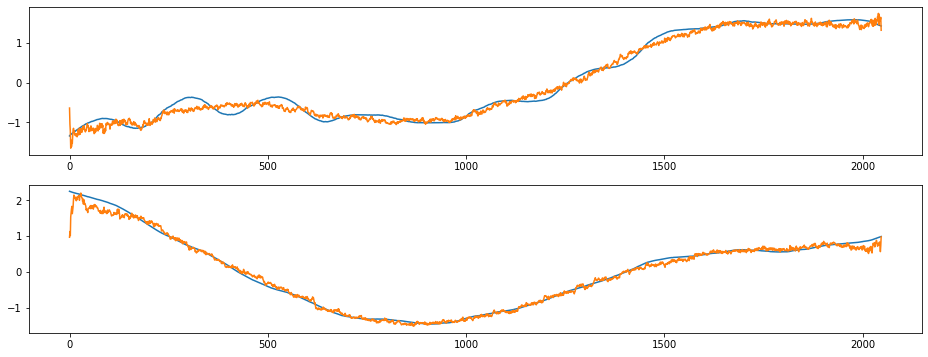

In [41]:
for i in range(10):
    around_peak_index = around_peak_indices[i]

    print('index: ', around_peak_index)
    print("MAE: ", MAE_train[around_peak_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_peak_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_peak_index].squeeze()
    pred_signal = train_pred[around_peak_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# around a point

In [ ]:
around_point_indices = np.argsort(np.abs(MAE_train - 6))

In [ ]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [42]:
import keras

In [43]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [44]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

TensorShape([1, 8, 8])

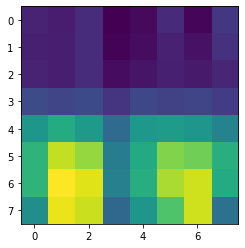

In [45]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

index:  130506
MAE:  0.04087548542043844
n_bunches       1868
bunch_index     1534
bunch_number     829
Name: 3538619, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6346/instability_data/06346_Inst_B1H_Q7_20171029_14h39m14s.h5


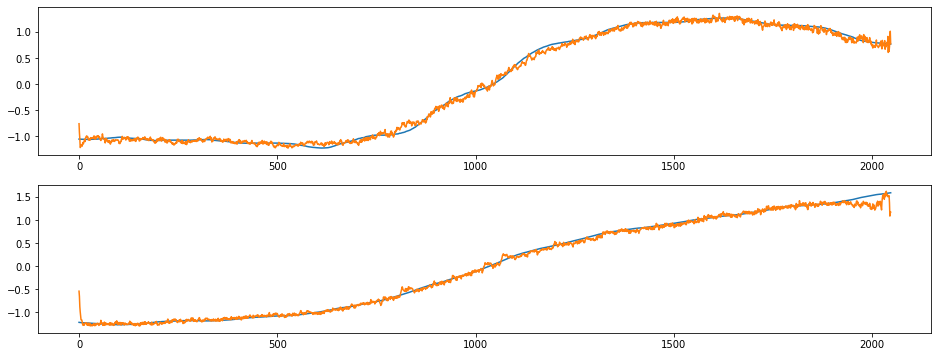

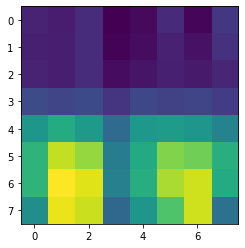

index:  158258
MAE:  0.0417306575917285
n_bunches       2556
bunch_index     3311
bunch_number    2461
Name: 2584334, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7259/instability_data/07259_Inst_B1H_Q7_20181005_02h39m14s.h5


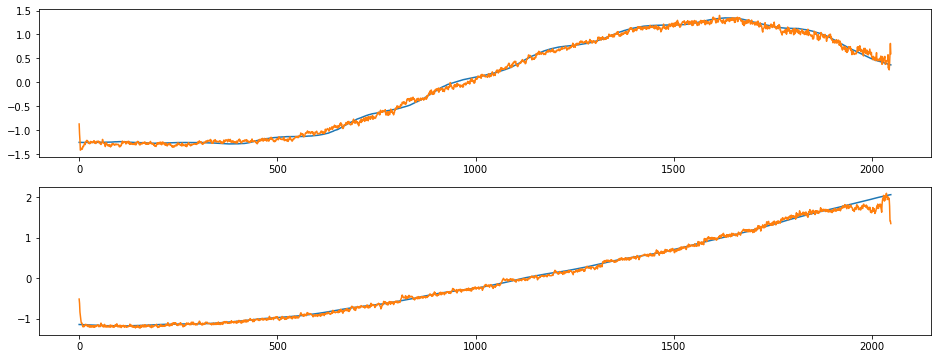

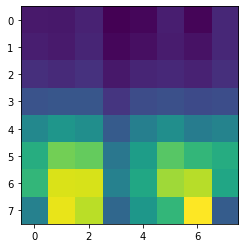

index:  207137
MAE:  0.04175235823735654
n_bunches       672
bunch_index     417
bunch_number    108
Name: 8925805, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6585/instability_data/06585_Inst_B1H_Q7_20180421_12h48m14s.h5


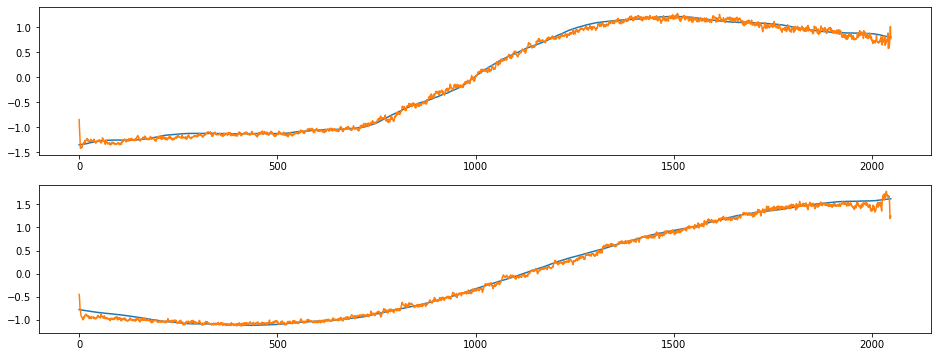

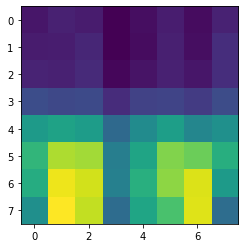

index:  322920
MAE:  0.04179790179728794
n_bunches       2556
bunch_index     1118
bunch_number     809
Name: 2753232, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6956/instability_data/06956_Inst_B1H_Q7_20180721_20h10m10s.h5


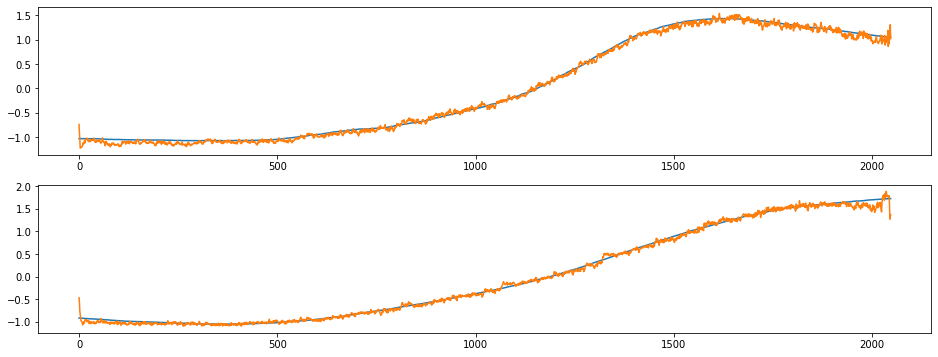

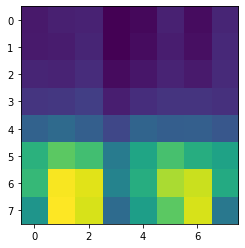

index:  182395
MAE:  0.042573829771125504
n_bunches        468
bunch_index     1644
bunch_number     462
Name: 7128903, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6576/instability_data/06576_Inst_B1H_Q7_20180419_19h33m14s.h5


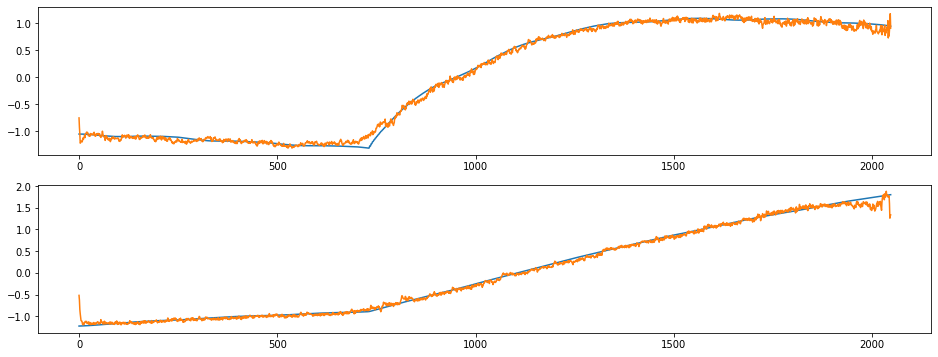

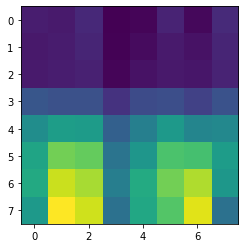

index:  124658
MAE:  0.042623381204067896
n_bunches       1916
bunch_index     1493
bunch_number     818
Name: 6002021, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170929_23h32m15s.h5


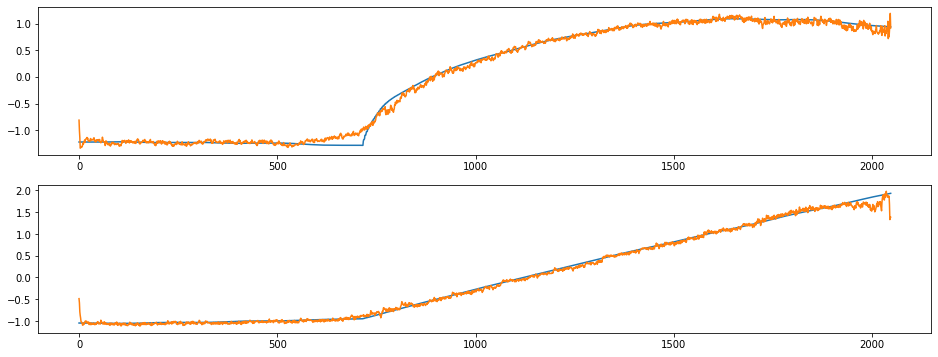

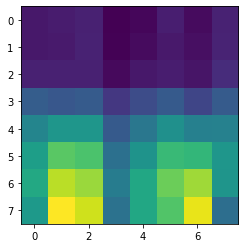

index:  316440
MAE:  0.04271055213339294
n_bunches       648
bunch_index     517
bunch_number     94
Name: 8149928, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181115_20h29m13s.h5


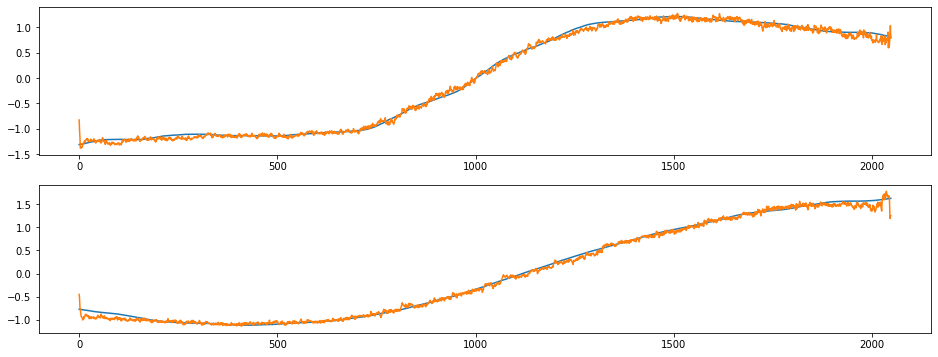

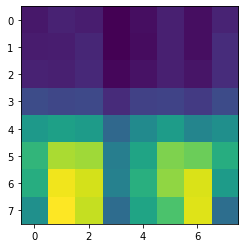

index:  356594
MAE:  0.04275711226318436
n_bunches       396
bunch_index     102
bunch_number     32
Name: 4640125, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7355/instability_data/07355_Inst_B1H_Q7_20181025_21h46m15s.h5


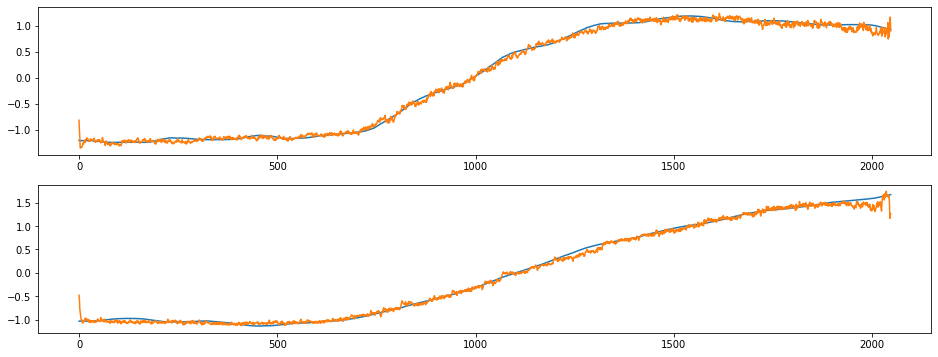

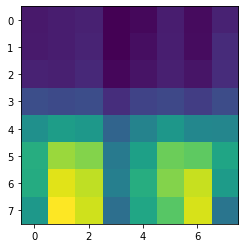

index:  389533
MAE:  0.04278771515024067
n_bunches       636
bunch_index     840
bunch_number    607
Name: 7142164, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7123/instability_data/07123_Inst_B1H_Q7_20180903_17h38m29s.h5


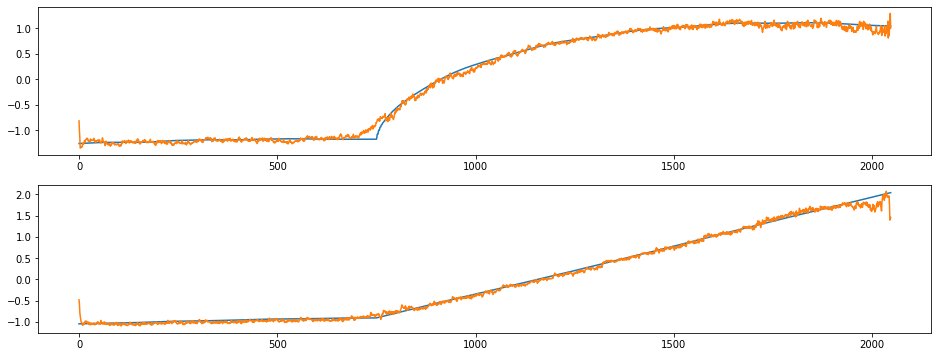

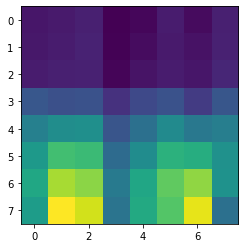

index:  48652
MAE:  0.04288523981896253
n_bunches        229
bunch_index     1015
bunch_number     212
Name: 6414425, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/instability_data/07466_Inst_B1H_Q7_20181122_17h42m39s.h5


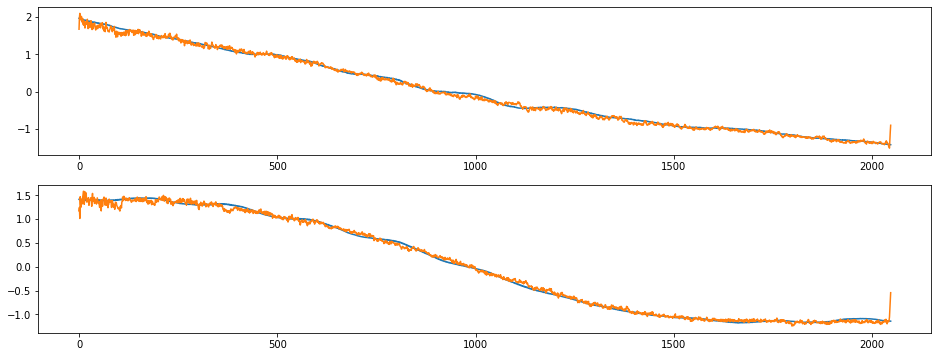

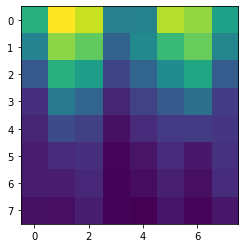

In [46]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

index:  149867
MAE:  0.5514533704274367
n_bunches       926
bunch_index     549
bunch_number    397
Name: 10795278, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6693/instability_data/06693_Inst_B1H_Q7_20180516_20h19m14s.h5


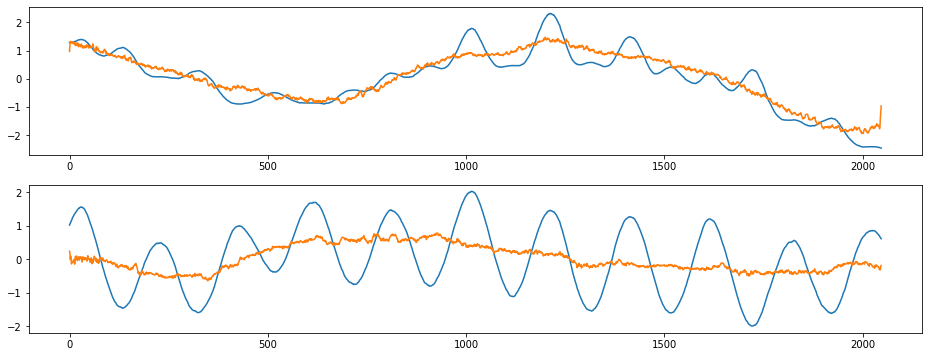

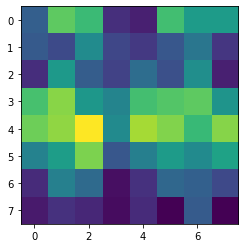

index:  384610
MAE:  0.5435191867503344
n_bunches       540
bunch_index     289
bunch_number    176
Name: 7321442, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6672/instability_data/06672_Inst_B1H_Q7_20180511_17h43m26s.h5


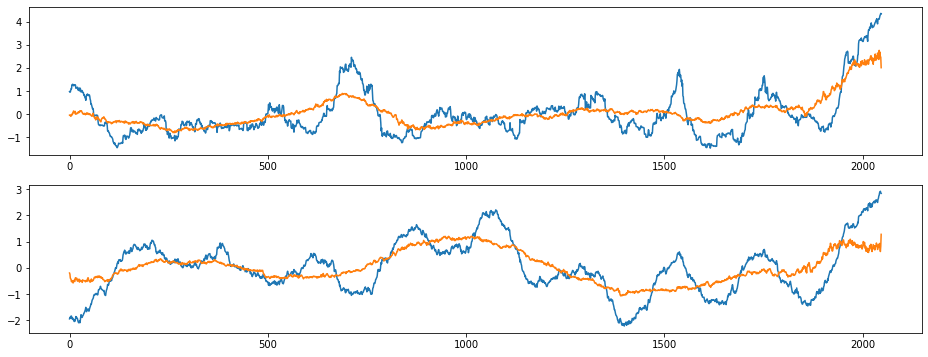

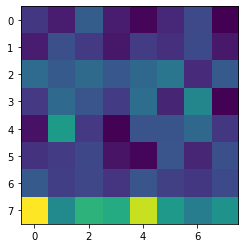

index:  246564
MAE:  0.5312561398517012
n_bunches       252
bunch_index     162
bunch_number     16
Name: 492317, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6576/instability_data/06576_Inst_B1H_Q7_20180419_19h22m52s.h5


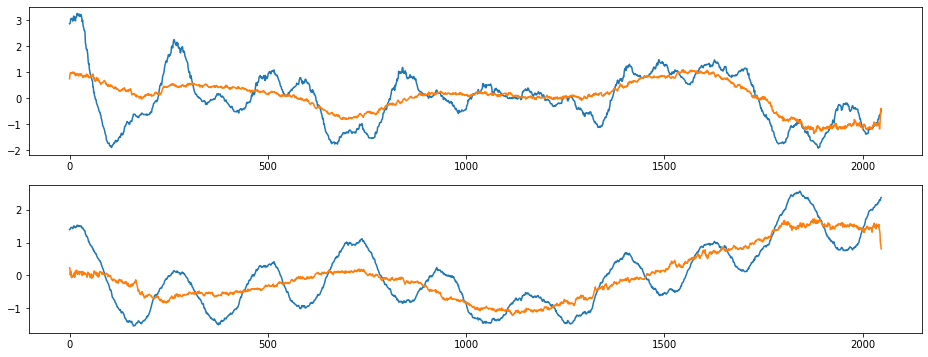

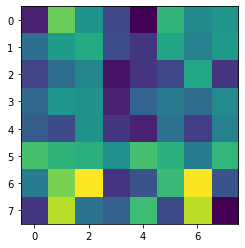

index:  88822
MAE:  0.5239509547789449
n_bunches       216
bunch_index      52
bunch_number      8
Name: 5288374, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6685/instability_data/06685_Inst_B1H_Q7_20180515_09h00m14s.h5


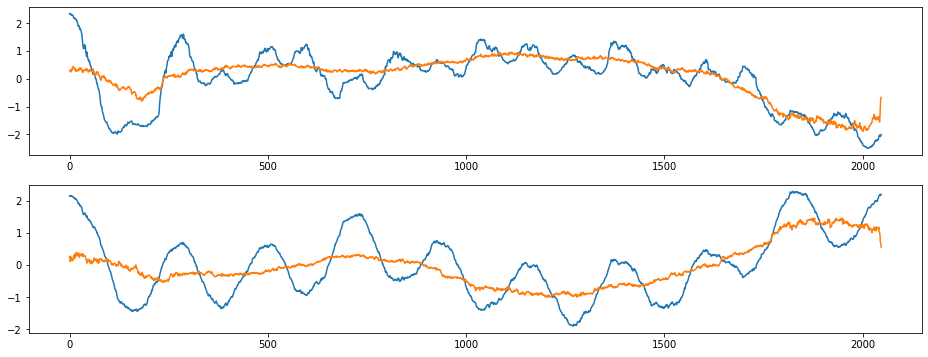

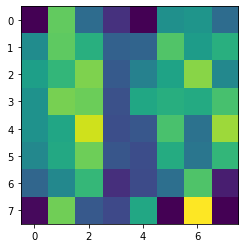

index:  3755
MAE:  0.4994455500005438
n_bunches        396
bunch_index     1145
bunch_number     393
Name: 8558283, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6396/instability_data/06396_Inst_B1H_Q7_20171116_22h07m05s.h5


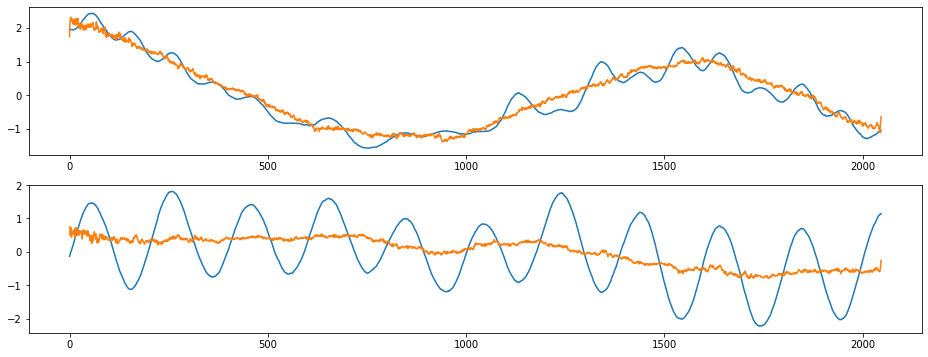

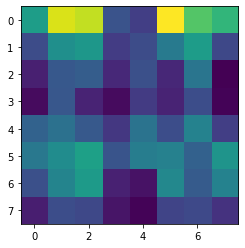

index:  221148
MAE:  0.49683955524330115
n_bunches       292
bunch_index     188
bunch_number     87
Name: 1468073, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/instability_data/06254_Inst_B1H_Q7_20170929_05h31m15s.h5


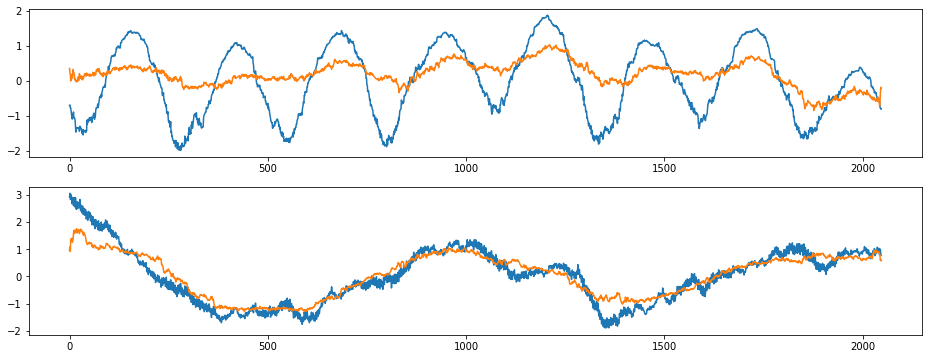

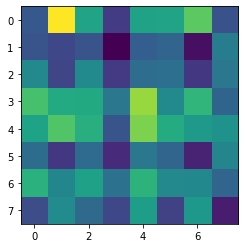

index:  362886
MAE:  0.4922952283855664
n_bunches       396
bunch_index     367
bunch_number    190
Name: 2630550, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6268/instability_data/06268_Inst_B1H_Q7_20171003_12h30m14s.h5


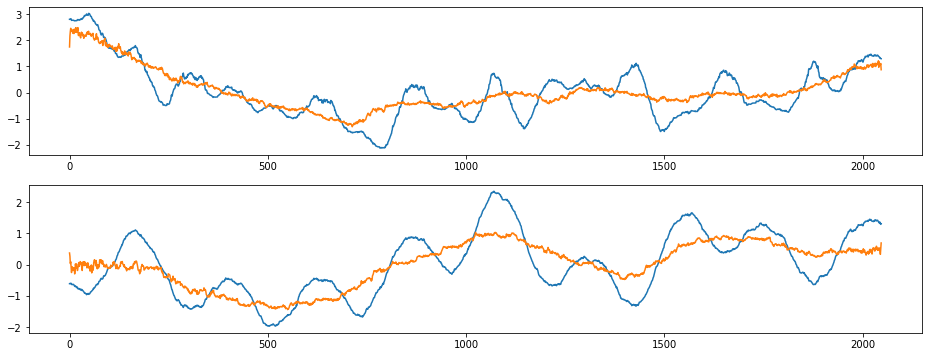

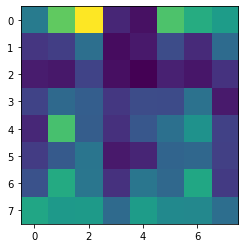

index:  135253
MAE:  0.491361819535928
n_bunches       2556
bunch_index     1852
bunch_number    1347
Name: 2270229, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_07h16m14s.h5


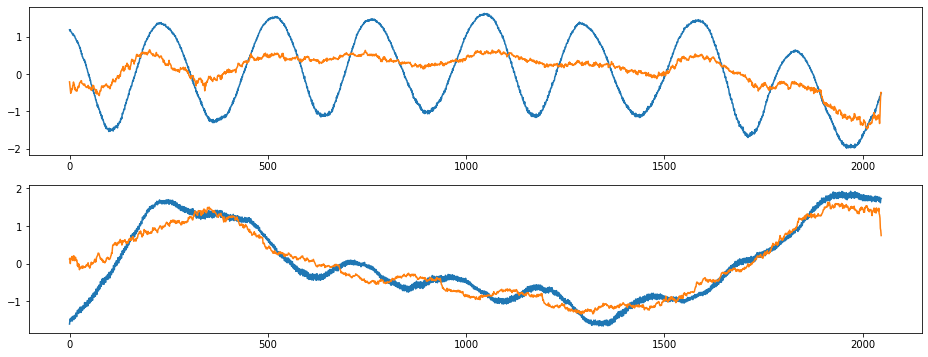

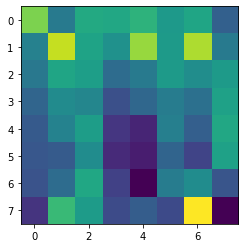

index:  96497
MAE:  0.4906566256442923
n_bunches       924
bunch_index     147
bunch_number     91
Name: 2958333, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7271/instability_data/07271_Inst_B1H_Q7_20181009_17h18m56s.h5


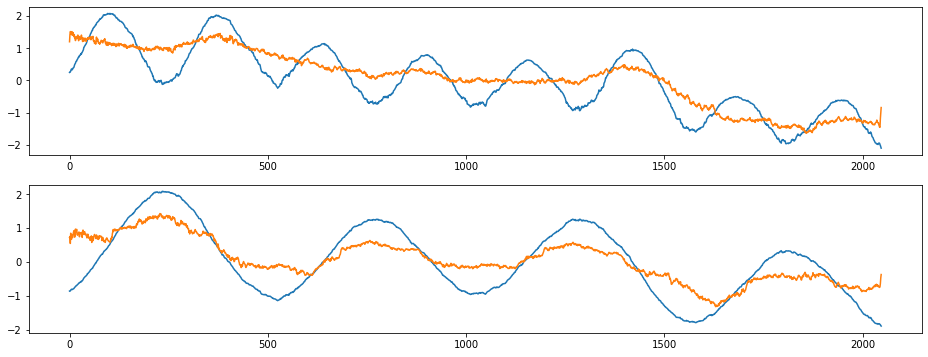

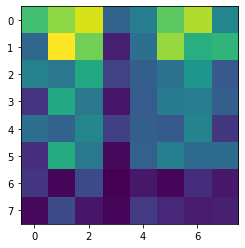

index:  238152
MAE:  0.48887903851530845
n_bunches       428
bunch_index     580
bunch_number    304
Name: 9291719, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6357/instability_data/06357_Inst_B1H_Q7_20171102_15h39m14s.h5


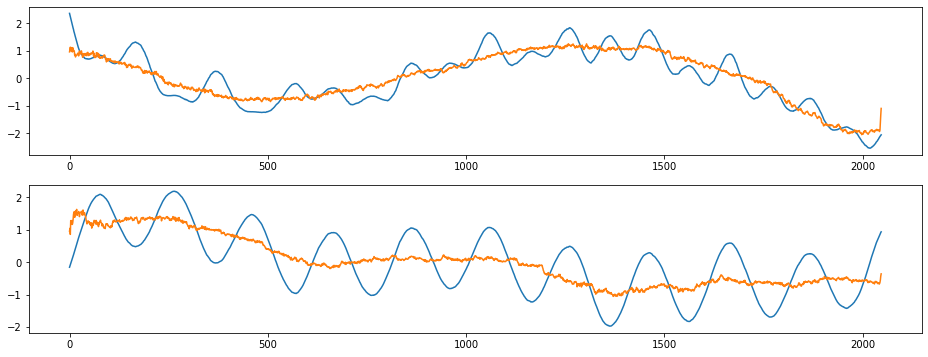

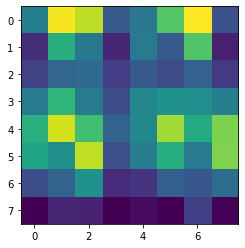

index:  26383
MAE:  0.48816638173667004
n_bunches       1868
bunch_index      633
bunch_number     338
Name: 7364097, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6283/instability_data/06283_Inst_B1H_Q7_20171008_07h31m14s.h5


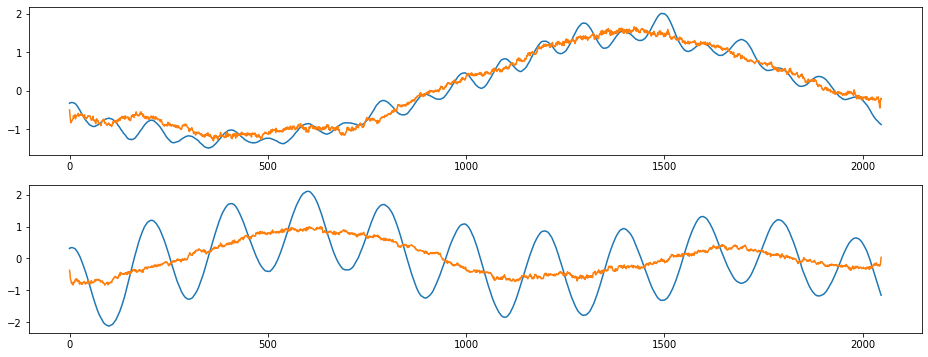

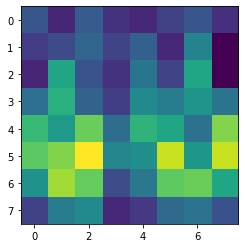

index:  10695
MAE:  0.48780869536567506
n_bunches       1068
bunch_index      334
bunch_number     233
Name: 6337768, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7048/instability_data/07048_Inst_B1H_Q7_20180813_04h41m39s.h5


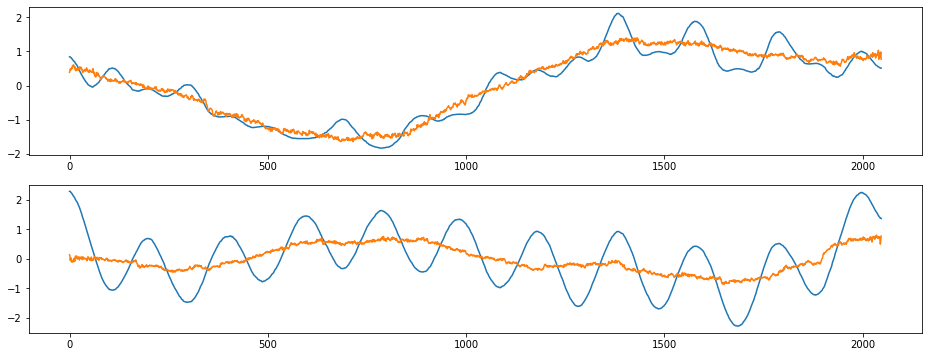

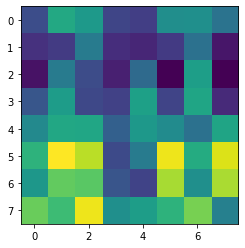

index:  49749
MAE:  0.4839640053556321
n_bunches       1188
bunch_index      598
bunch_number     297
Name: 10402409, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6170/instability_data/06170_Inst_B1H_Q7_20170905_19h51m48s.h5


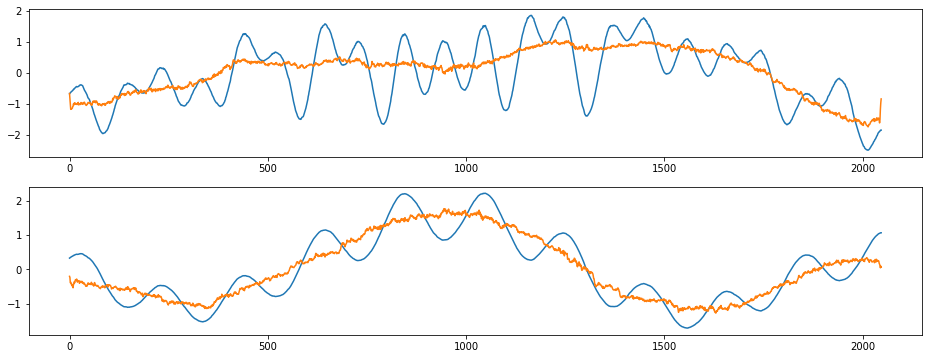

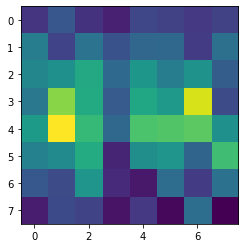

index:  214347
MAE:  0.47928502031640663
n_bunches       372
bunch_index     419
bunch_number     72
Name: 11017109, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7444/instability_data/07444_Inst_B1H_Q7_20181115_01h59m14s.h5


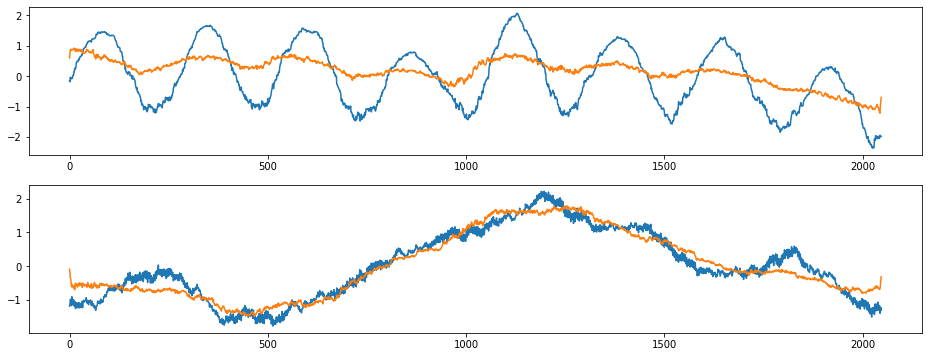

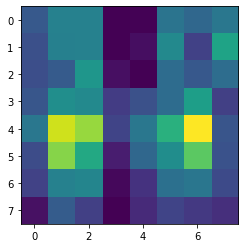

index:  224296
MAE:  0.47895801167353846
n_bunches        733
bunch_index     2052
bunch_number     431
Name: 5436947, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7467/instability_data/07467_Inst_B1H_Q7_20181123_10h41m14s.h5


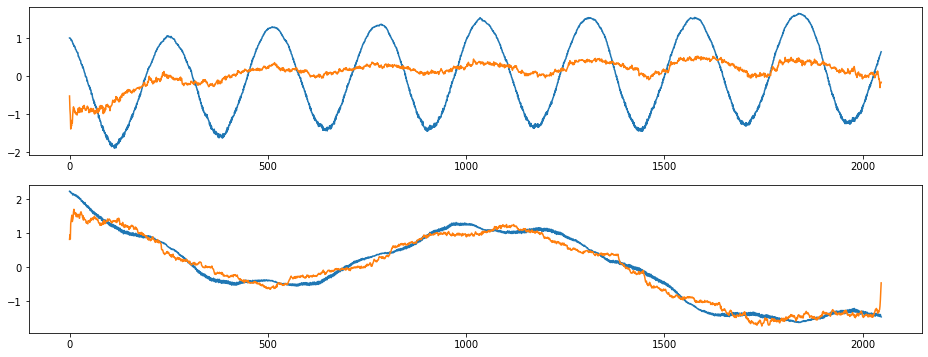

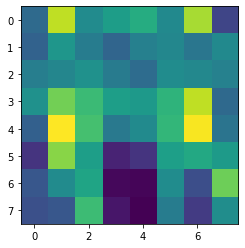

index:  223664
MAE:  0.47715686923907097
n_bunches       1887
bunch_index     1923
bunch_number    1042
Name: 10871021, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6629/instability_data/06629_Inst_B1H_Q7_20180501_16h08m13s.h5


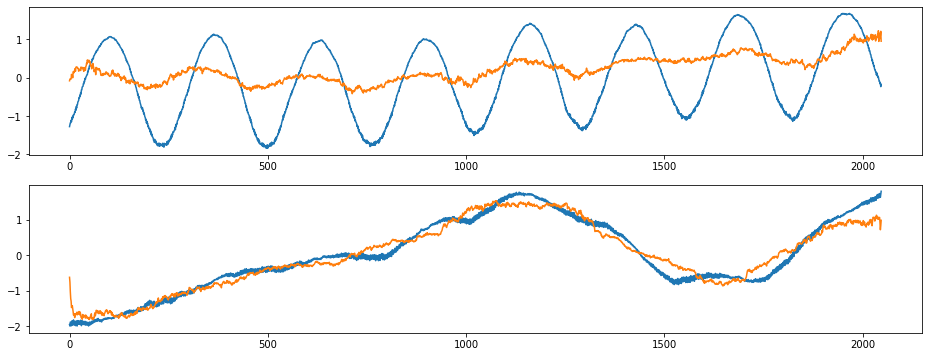

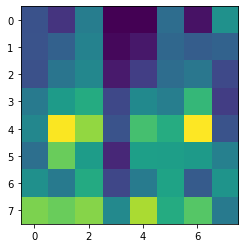

index:  137186
MAE:  0.473016943617776
n_bunches       468
bunch_index     464
bunch_number    210
Name: 8805467, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7366/instability_data/07366_Inst_B1H_Q7_20181027_02h26m10s.h5


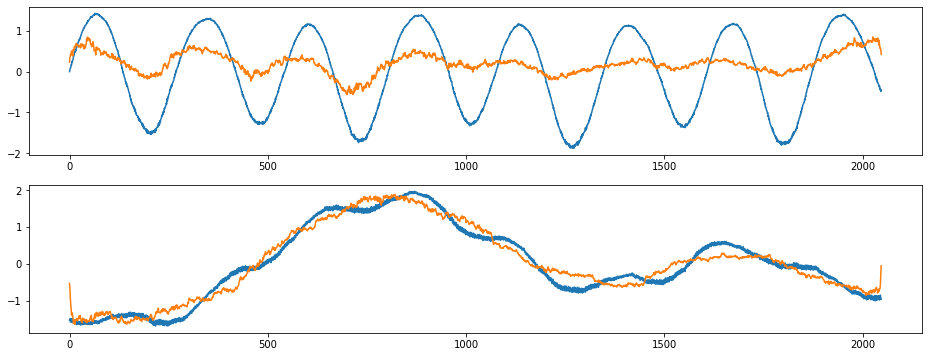

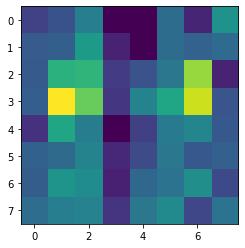

index:  193998
MAE:  0.47204209183879725
n_bunches       1868
bunch_index      955
bunch_number     512
Name: 9948204, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/instability_data/06348_Inst_B1H_Q7_20171030_21h51m14s.h5


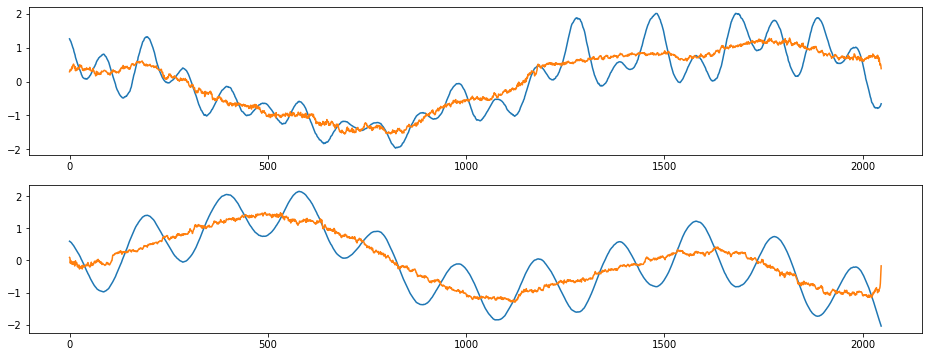

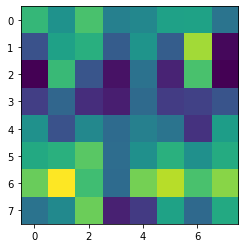

index:  225669
MAE:  0.46865574796563336
n_bunches       2175
bunch_index      400
bunch_number     286
Name: 5778361, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_16h42m14s.h5


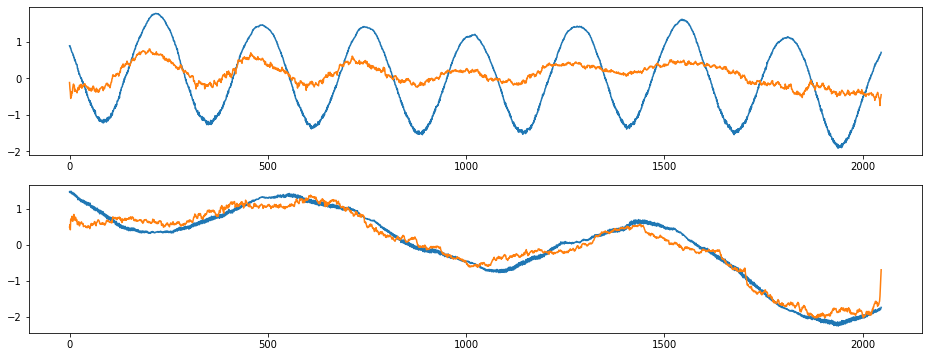

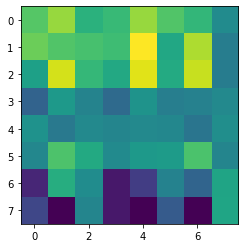

index:  25257
MAE:  0.4640085291715511
n_bunches        36
bunch_index     199
bunch_number     35
Name: 8463253, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7451/instability_data/07451_Inst_B1H_Q7_20181117_13h12m48s.h5


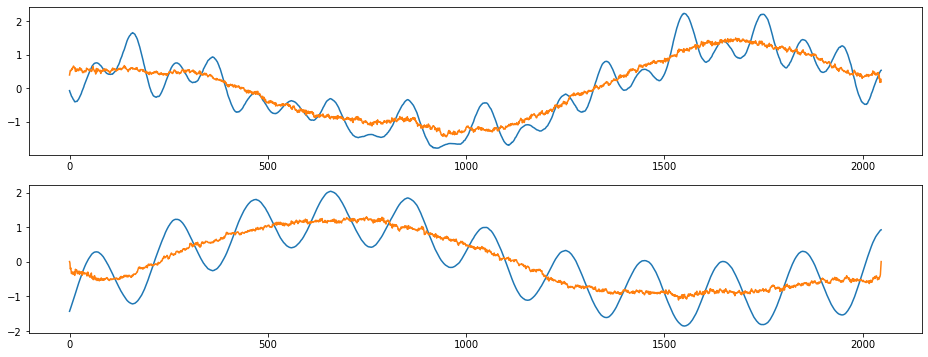

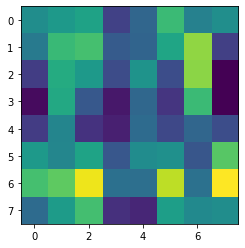

index:  139612
MAE:  0.4638980593712265
n_bunches       1916
bunch_index     2534
bunch_number    1410
Name: 4919888, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_07h40m14s.h5


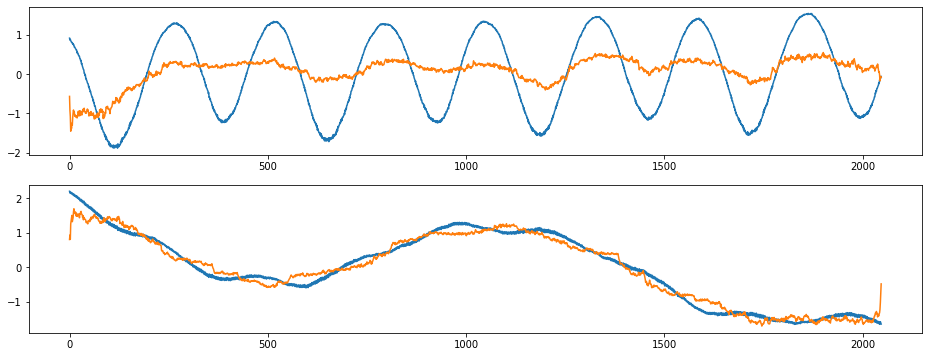

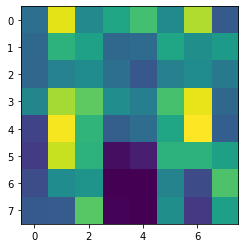

index:  140428
MAE:  0.4621947169682996
n_bunches        780
bunch_index     1314
bunch_number     688
Name: 11484790, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_01h28m03s.h5


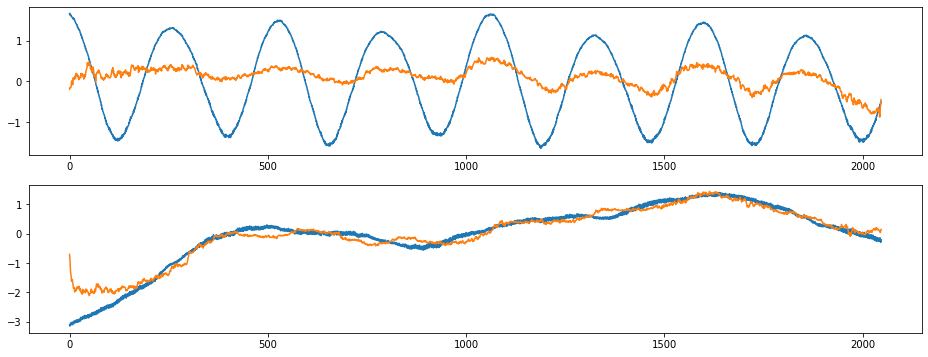

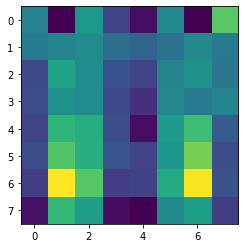

index:  139308
MAE:  0.46137249367386624
n_bunches       1868
bunch_index     1426
bunch_number     779
Name: 1126103, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6276/instability_data/06276_Inst_B1H_Q7_20171006_16h49m14s.h5


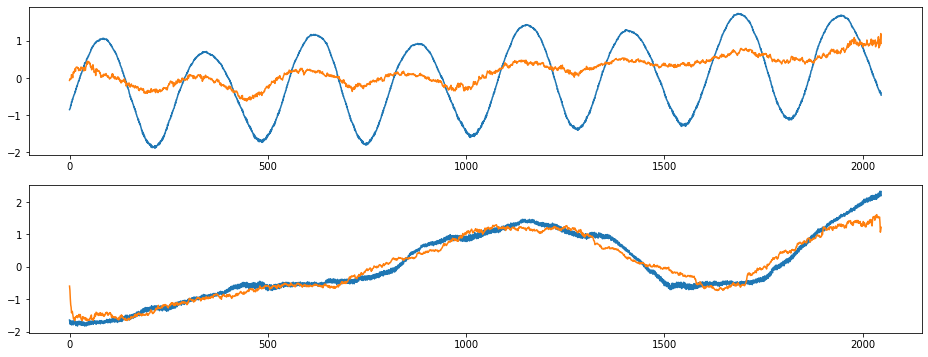

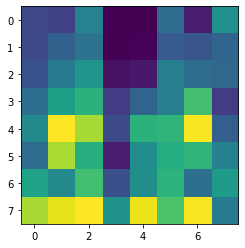

index:  257289
MAE:  0.4584903863788781
n_bunches       2556
bunch_index      149
bunch_number      74
Name: 8621142, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6696/instability_data/06696_Inst_B1H_Q7_20180518_10h41m14s.h5


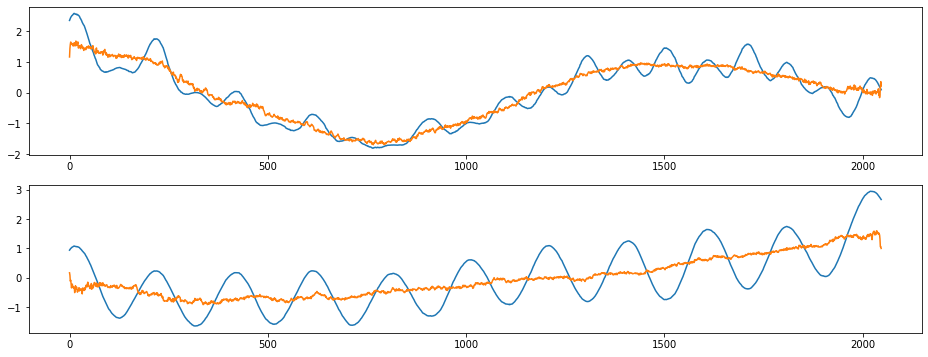

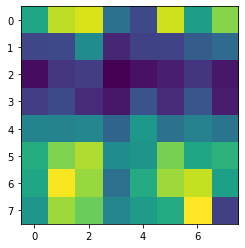

index:  225741
MAE:  0.4581684855515667
n_bunches       1868
bunch_index     2753
bunch_number    1478
Name: 9464033, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6358/instability_data/06358_Inst_B1H_Q7_20171102_19h32m14s.h5


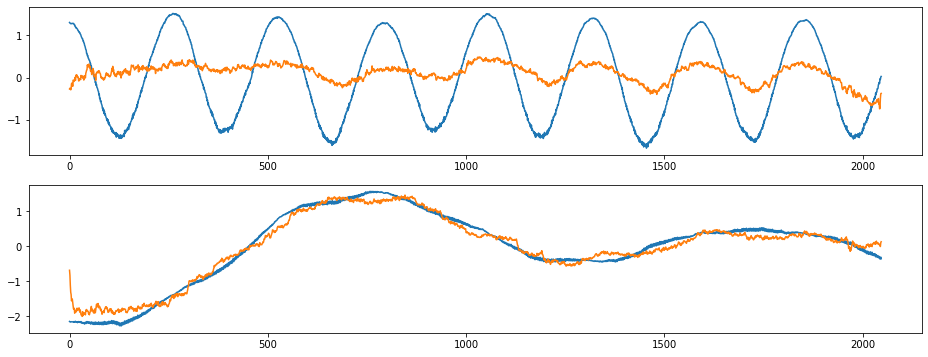

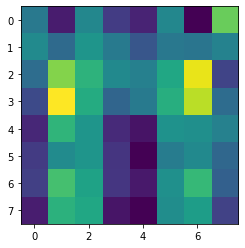

index:  173039
MAE:  0.45773167629328837
n_bunches       492
bunch_index     854
bunch_number    444
Name: 5909714, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6264/instability_data/06264_Inst_B1H_Q7_20171002_13h10m50s.h5


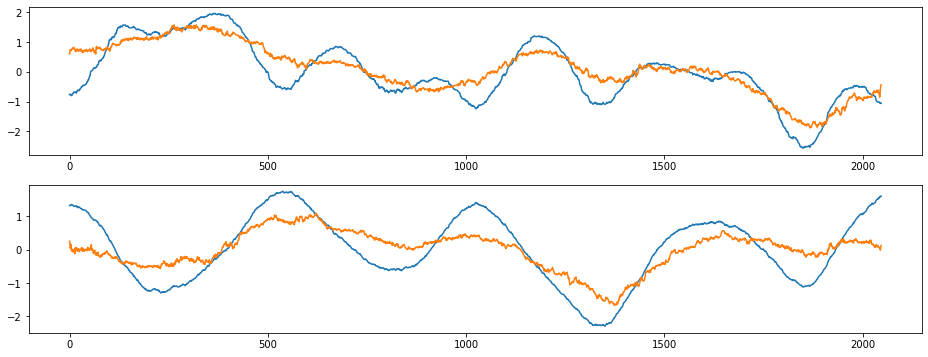

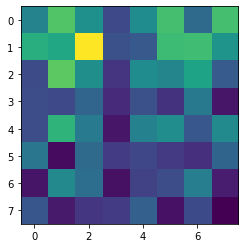

index:  377520
MAE:  0.4577002717046106
n_bunches       1916
bunch_index     1020
bunch_number     560
Name: 3671098, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6193/instability_data/06193_Inst_B1H_Q7_20170913_00h56m14s.h5


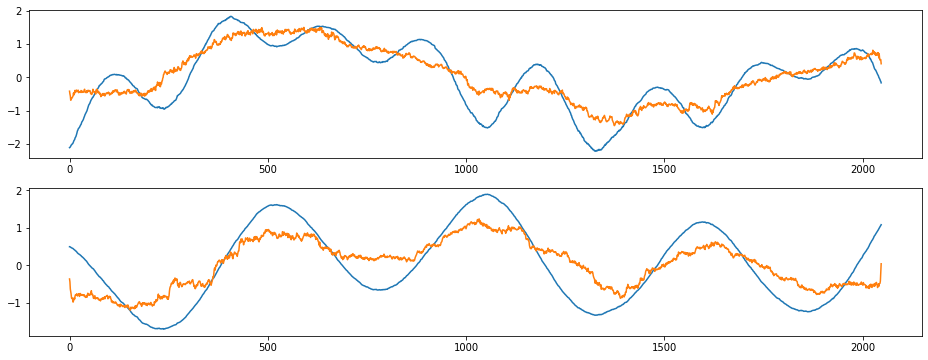

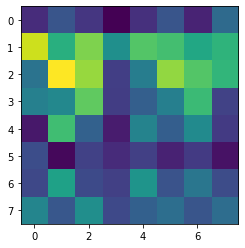

index:  220927
MAE:  0.4562352695182723
n_bunches        649
bunch_index     1510
bunch_number     316
Name: 4506111, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7465/instability_data/07465_Inst_B1H_Q7_20181122_12h52m15s.h5


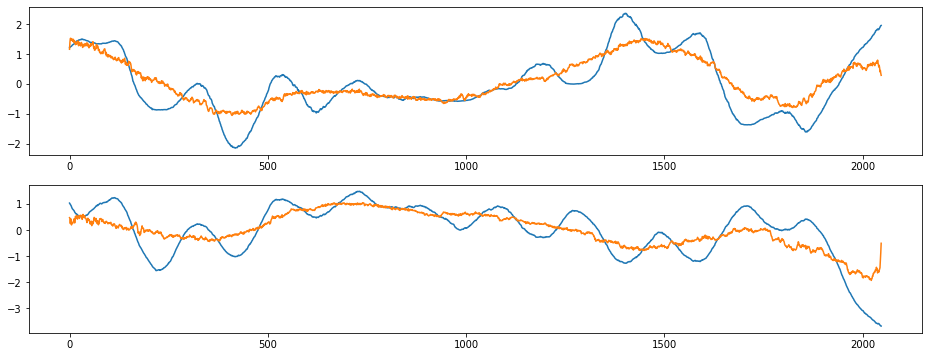

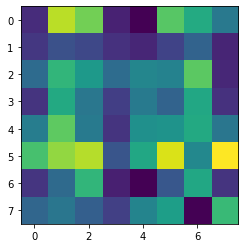

index:  97142
MAE:  0.4542690776903199
n_bunches        72
bunch_index     396
bunch_number     34
Name: 3287492, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7352/instability_data/07352_Inst_B1H_Q7_20181025_16h15m40s.h5


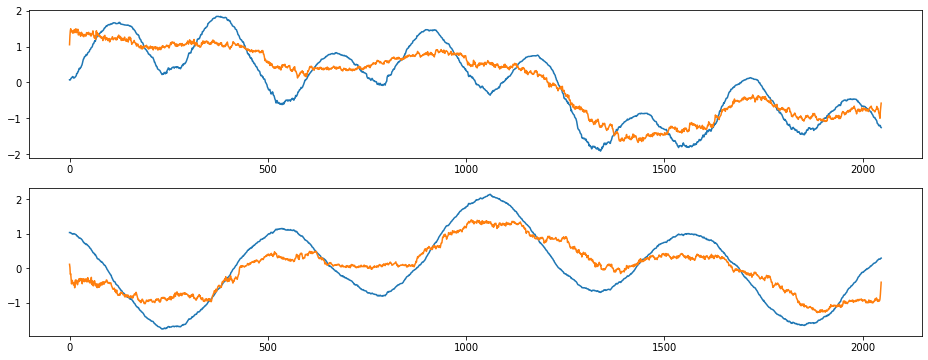

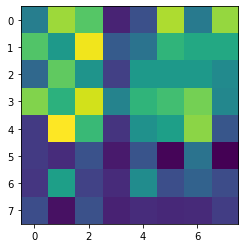

index:  223876
MAE:  0.4538400623678013
n_bunches       428
bunch_index     682
bunch_number    368
Name: 3591177, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6274/instability_data/06274_Inst_B1H_Q7_20171005_18h51m14s.h5


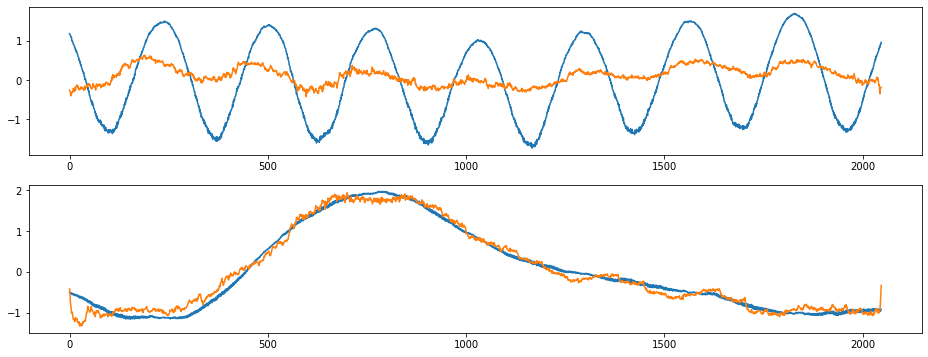

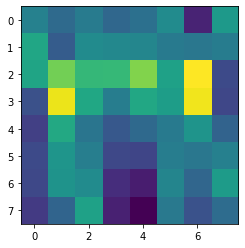

index:  229826
MAE:  0.4533902366434664
n_bunches       268
bunch_index     173
bunch_number     31
Name: 2764376, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7441/instability_data/07441_Inst_B1H_Q7_20181113_05h34m45s.h5


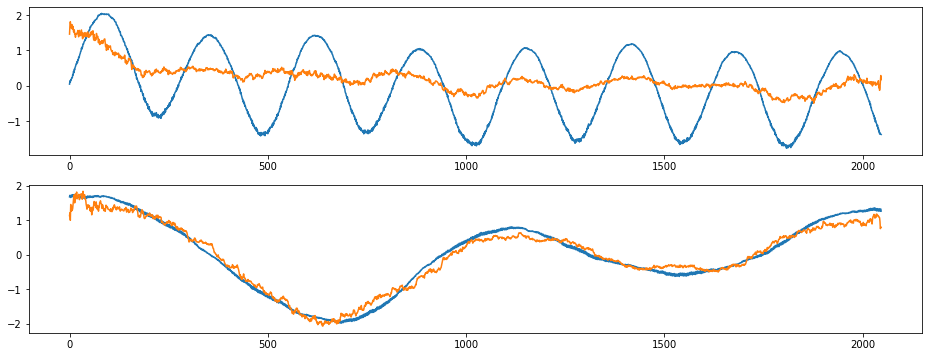

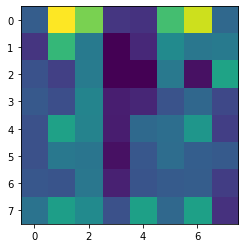

index:  14701
MAE:  0.45275979017550927
n_bunches       2556
bunch_index     2449
bunch_number    1821
Name: 11218518, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7031/instability_data/07031_Inst_B1H_Q7_20180806_17h22m15s.h5


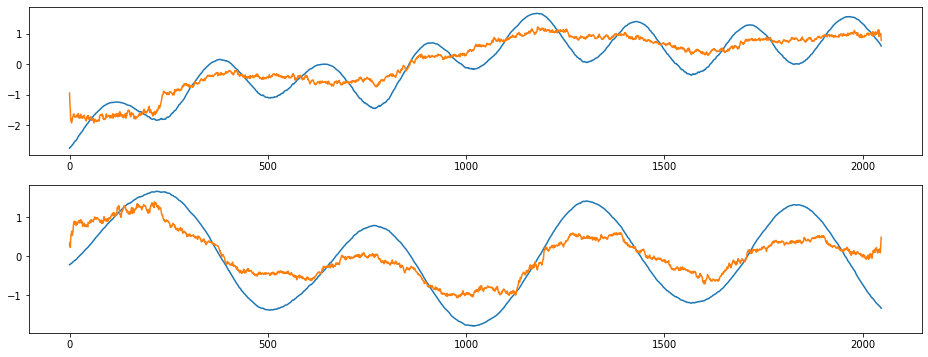

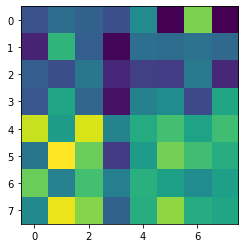

index:  141681
MAE:  0.45226021809763695
n_bunches       1212
bunch_index     1400
bunch_number    1032
Name: 6116090, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7097/instability_data/07097_Inst_B1H_Q7_20180828_14h30m15s.h5


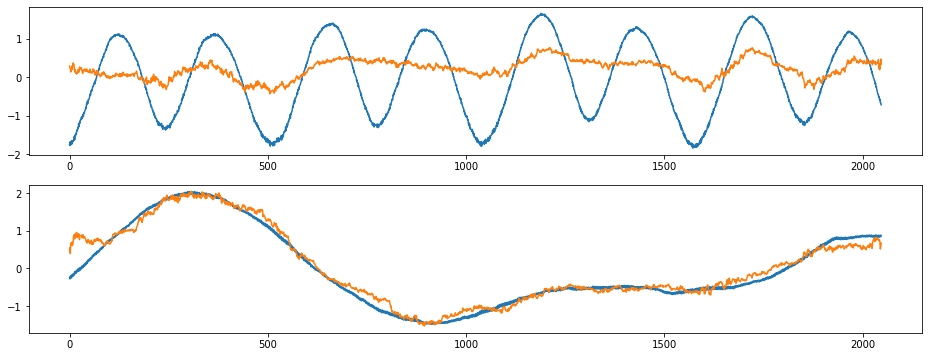

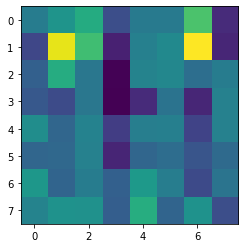

index:  144582
MAE:  0.45176137518248727
n_bunches       444
bunch_index     426
bunch_number    198
Name: 4015000, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6988/instability_data/06988_Inst_B1H_Q7_20180727_05h47m14s.h5


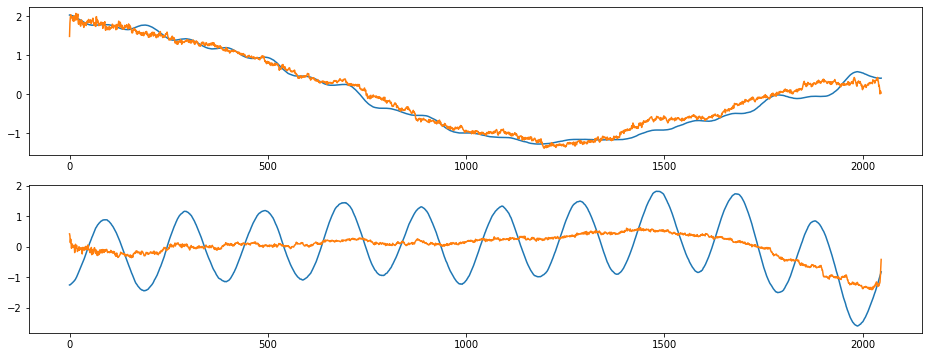

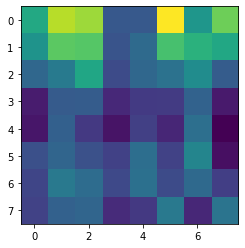

index:  107646
MAE:  0.4507378492147744
n_bunches       1308
bunch_index      217
bunch_number     160
Name: 3335462, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6588/instability_data/06588_Inst_B1H_Q7_20180421_17h06m14s.h5


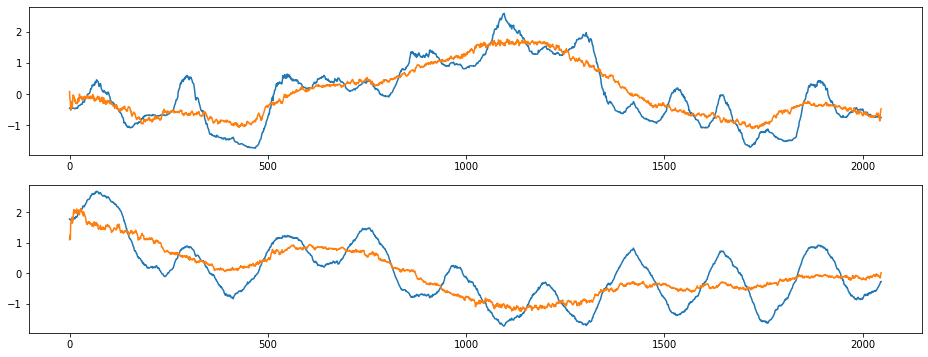

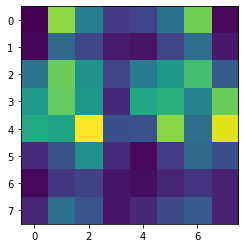

index:  373040
MAE:  0.4497359890480567
n_bunches       264
bunch_index     159
bunch_number     13
Name: 1720024, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7269/instability_data/07269_Inst_B1H_Q7_20181008_23h31m09s.h5


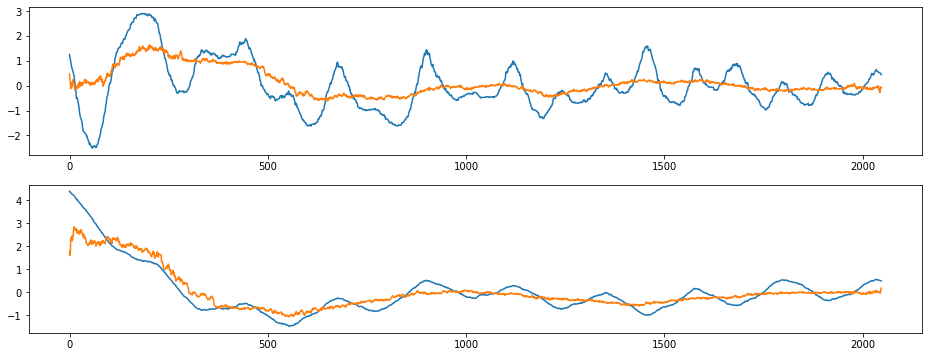

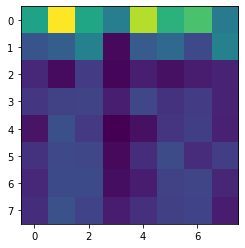

index:  343383
MAE:  0.4491821300925929
n_bunches       180
bunch_index      81
bunch_number     35
Name: 10170830, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6253/instability_data/06253_Inst_B1H_Q7_20170928_12h58m15s.h5


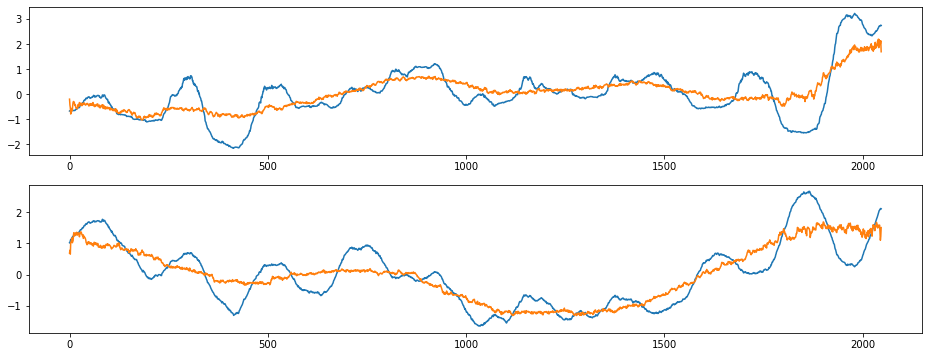

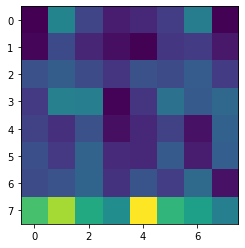

index:  323711
MAE:  0.4473837804534281
n_bunches       2556
bunch_index     1420
bunch_number    1052
Name: 7547359, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7018/instability_data/07018_Inst_B1H_Q7_20180804_15h41m25s.h5


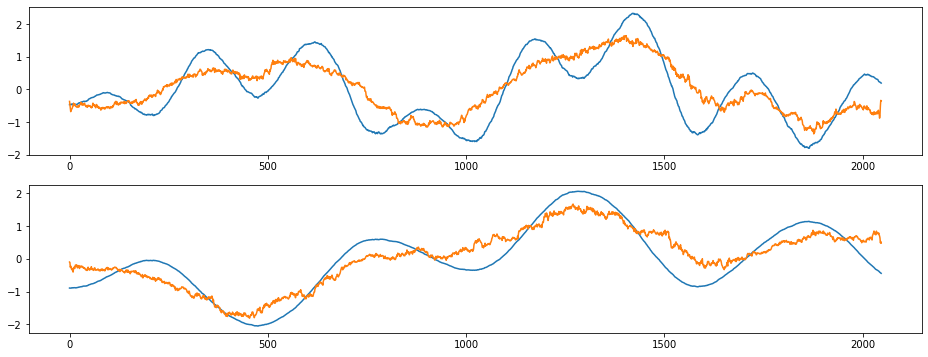

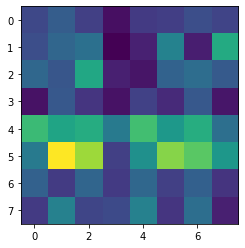

index:  140188
MAE:  0.44579755577654356
n_bunches        313
bunch_index     1319
bunch_number     275
Name: 11064503, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_16h56m42s.h5


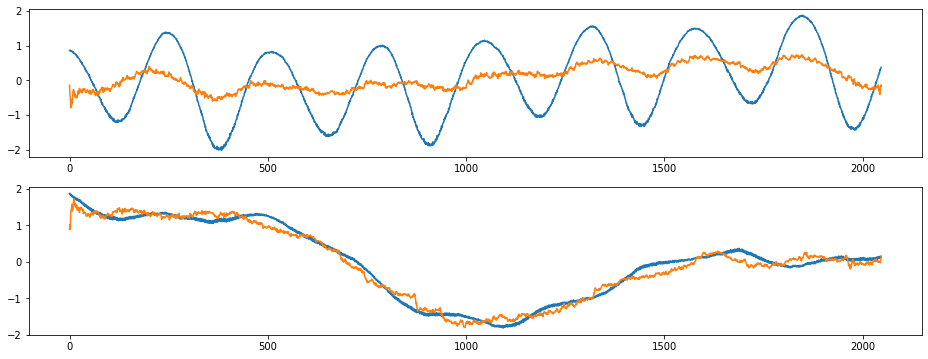

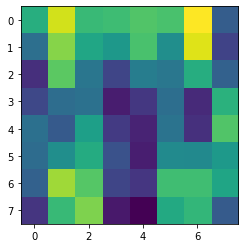

index:  218614
MAE:  0.4457142755260958
n_bunches       2556
bunch_index      480
bunch_number     341
Name: 7491904, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7031/instability_data/07031_Inst_B1H_Q7_20180806_21h10m14s.h5


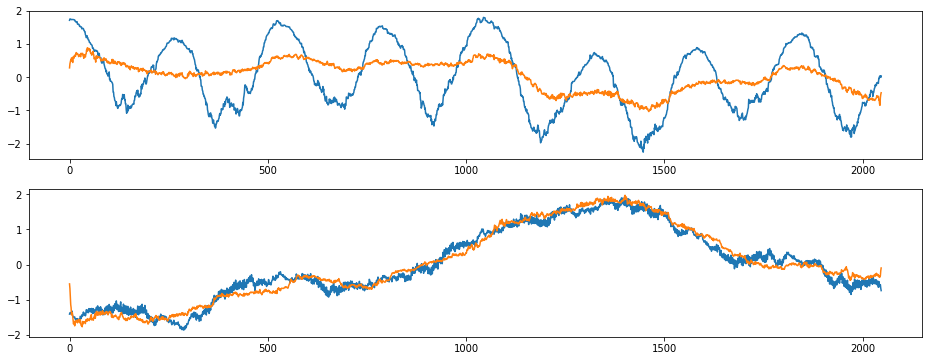

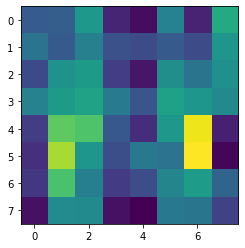

index:  310351
MAE:  0.44569475306831935
n_bunches       1227
bunch_index     1351
bunch_number     472
Name: 7112904, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6690/instability_data/06690_Inst_B1H_Q7_20180516_11h17m14s.h5


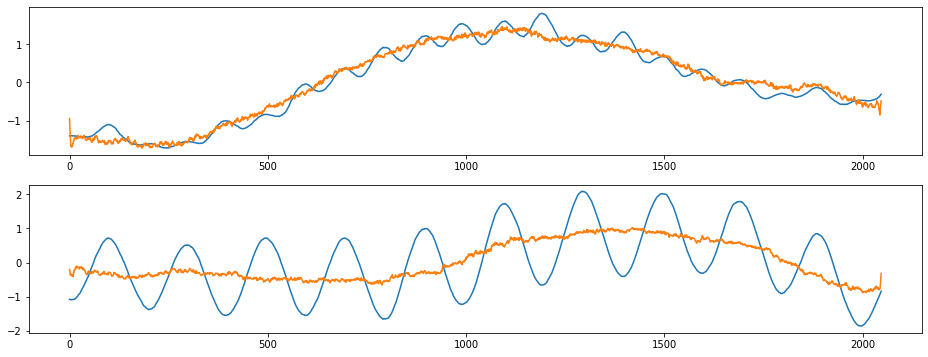

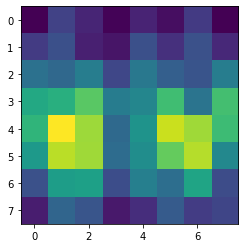

index:  59317
MAE:  0.4455594494294822
n_bunches        480
bunch_index     1977
bunch_number     370
Name: 10406205, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7449/instability_data/07449_Inst_B1H_Q7_20181116_17h41m14s.h5


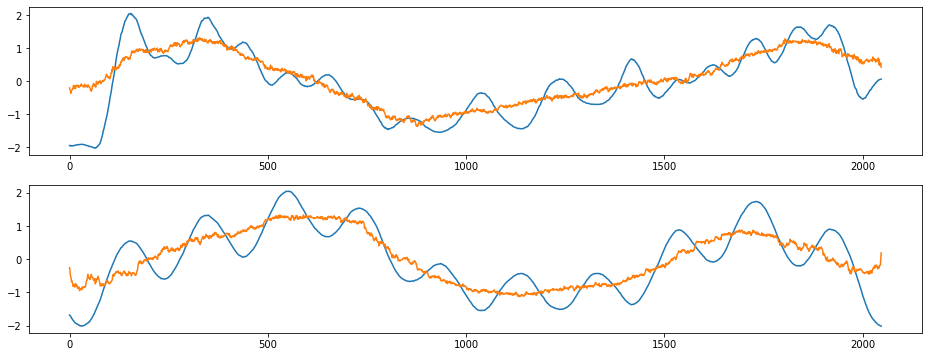

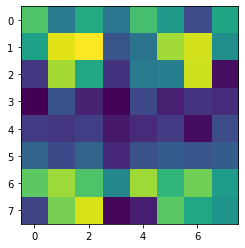

index:  318629
MAE:  0.4453060474973378
n_bunches        733
bunch_index     2401
bunch_number     505
Name: 1776507, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7475/instability_data/07475_Inst_B1H_Q7_20181126_17h58m14s.h5


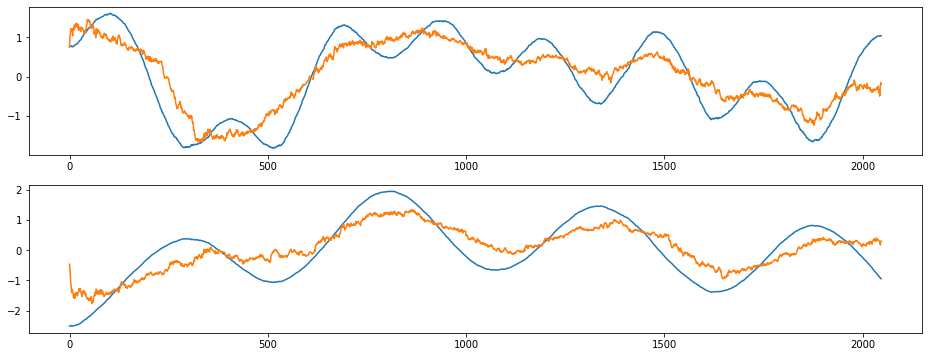

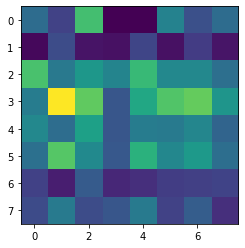

index:  292543
MAE:  0.4450455968962165
n_bunches       396
bunch_index     673
bunch_number    353
Name: 2731280, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6264/instability_data/06264_Inst_B1H_Q7_20171002_13h09m29s.h5


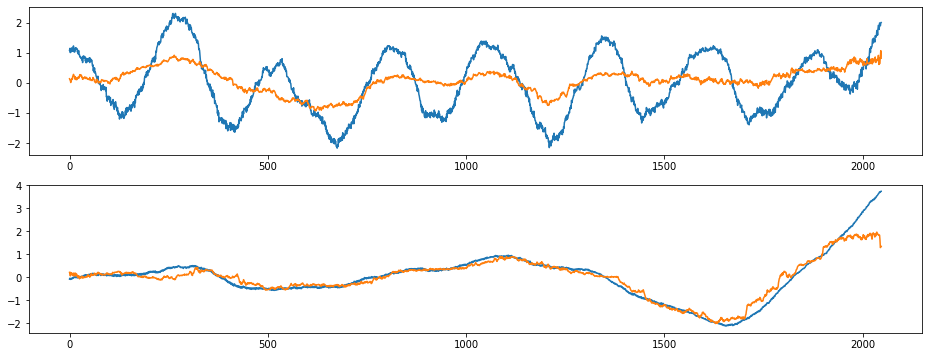

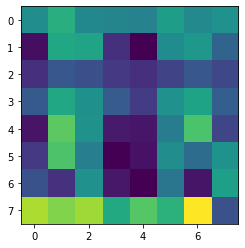

index:  18059
MAE:  0.44504475377518227
n_bunches       1868
bunch_index      658
bunch_number     355
Name: 3398185, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6362/instability_data/06362_Inst_B1H_Q7_20171104_23h57m15s.h5


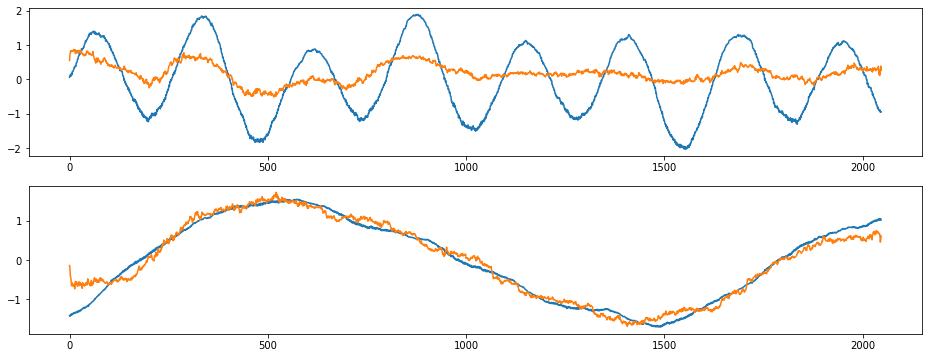

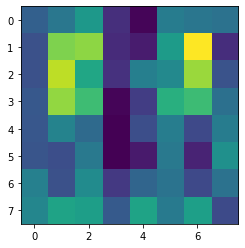

index:  164509
MAE:  0.44474519543808855
n_bunches       636
bunch_index     421
bunch_number    289
Name: 1723785, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7040/instability_data/07040_Inst_B1H_Q7_20180809_19h13m07s.h5


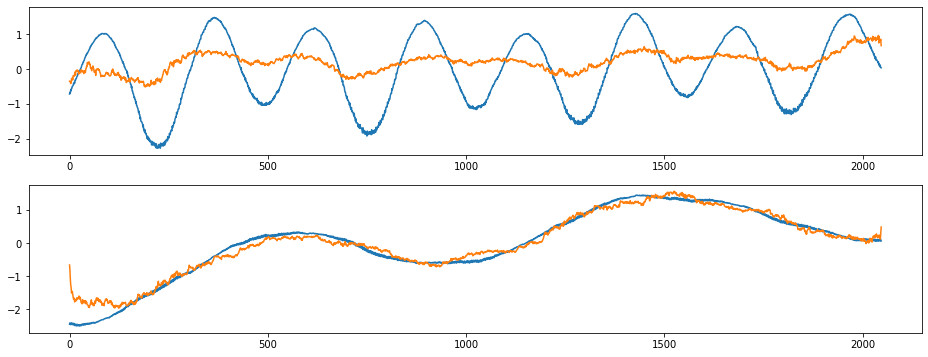

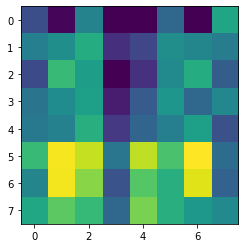

index:  380895
MAE:  0.4445841919411567
n_bunches       852
bunch_index     385
bunch_number    174
Name: 7397618, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7365/instability_data/07365_Inst_B1H_Q7_20181026_23h11m42s.h5


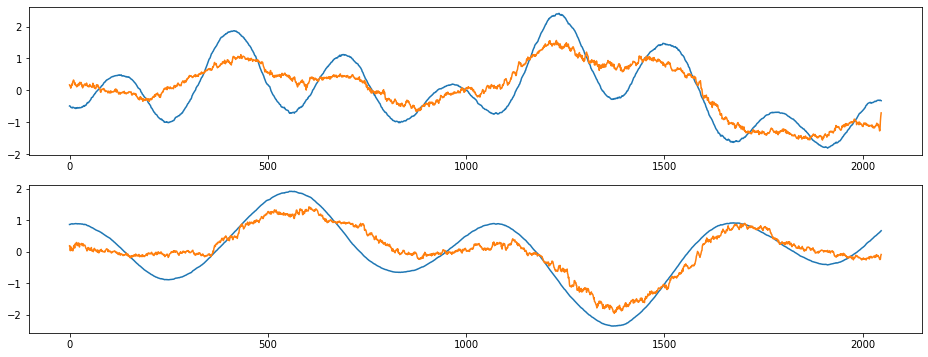

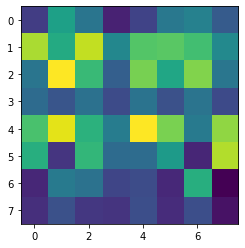

index:  174370
MAE:  0.44402242840572426
n_bunches       1452
bunch_index     2160
bunch_number     910
Name: 2225907, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6891/instability_data/06891_Inst_B1H_Q7_20180706_17h59m14s.h5


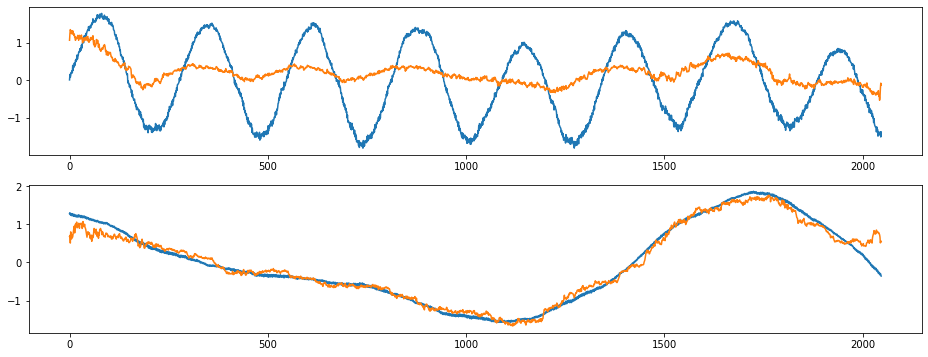

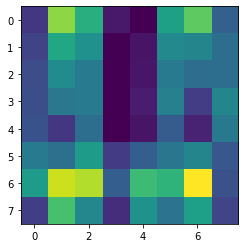

index:  165651
MAE:  0.4439238113120772
n_bunches        460
bunch_index     3054
bunch_number     375
Name: 4788499, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/instability_data/07464_Inst_B1H_Q7_20181122_04h55m14s.h5


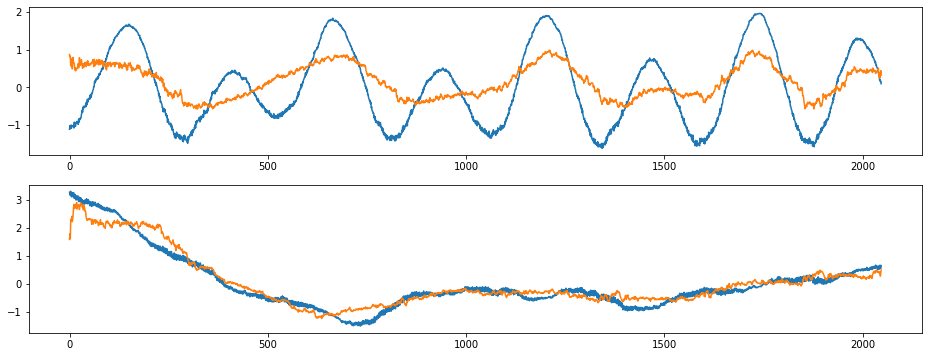

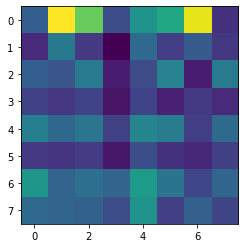

index:  149059
MAE:  0.4435313071447839
n_bunches       1868
bunch_index      415
bunch_number     216
Name: 11090977, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6276/instability_data/06276_Inst_B1H_Q7_20171006_14h15m25s.h5


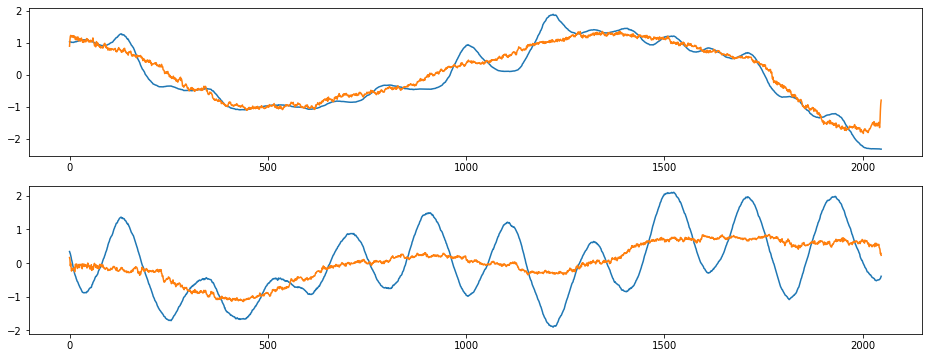

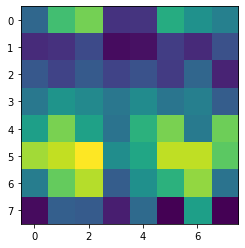

In [47]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [ ]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [ ]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [ ]:
np.save(model_latent_space_file, latent_dataset)

In [ ]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [ ]:
np.save(model_train_dataset_file, train_dataset)

In [ ]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [ ]:
np.save(model_latent_input_file, latent_input_data)